In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk import bigrams, word_tokenize
import nltk
import re
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
file = "clusterFRESPT.xlsx"

In [ ]:
data = pd.read_excel(file)

In [ ]:
data['Aspects_Polarity'] = data['Aspects_Polarity'].str.lstrip()

In [ ]:
file ="DadosFinais2.xlsx"

In [ ]:
res = pd.read_excel(file, 'Reservas')
prop = pd.read_excel(file, 'Propriedades')
guests = pd.read_excel(file, 'Hóspedes')
data1 = pd.read_excel(file, 'Reviews - geral')
reviews2 = pd.read_excel(file, 'Reviews - detalhe')

In [ ]:
guests.head(9)

ReservationId   Age GuestCountry       Continent
0          43464  59.0           DE  Western Europe
1          53670  34.0           PT  Western Europe
2          52032  55.0           FR  Western Europe
3          53437  58.0           EC   South America
4          49332  68.0           AU         Oceania
5          58758  39.0           SI  Eastern Europe
6          57452  30.0           GB  Western Europe
7          58880  62.0           US   North America
8          57323  62.0           CL   South America

In [ ]:
guests.isna().sum()

ReservationId    0
Age              3
GuestCountry     2
Continent        2
dtype: int64

In [ ]:
data.isna().sum()

ReservationId       0
RatingValue         0
Comments            0
Language            0
Translated          0
Polarity            0
NetPromoterScore    0
Aspects             0
Aspects_Polarity    0
Aspect_vectors      0
Cluster_Labels      0
dtype: int64

In [ ]:
guests =guests.dropna()

In [ ]:
age_intervals = range(0, 90, 5)  # Age groups from 0 to 85+ in 5-year intervals

# Define the labels for the age groups
age_labels = [f"{i}-{i+4}" if i < 85 else "85+" for i in age_intervals[:-1]]

# Create a new column 'age_group' based on 'age'
guests['age_group'] = pd.cut(guests['Age'], bins=age_intervals, labels=age_labels, right=False)

<ipython-input-505-3db7ae219316>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guests['age_group'] = pd.cut(guests['Age'], bins=age_intervals, labels=age_labels, right=False)


In [ ]:
guests['age_group'].value_counts()

age_group
25-29    1878
30-34    1769
35-39    1174
40-44     885
45-49     763
20-24     739
50-54     684
55-59     575
60-64     305
65-69     174
70-74      80
0-4        57
15-19      31
75-79      26
5-9         6
80-84       5
10-14       2
Name: count, dtype: int64

In [ ]:
reservation_age_map = dict(zip(guests['ReservationId'], guests['age_group']))

# Create a new column 'reviewer_age_group' in 'data' by looking up age_group based on ReservationId
data['reviewer_age_group'] = data['ReservationId'].map(reservation_age_map)

In [ ]:
reservation_country_map = dict(zip(guests['ReservationId'], guests['GuestCountry']))

# Create a new column 'reviewer_nationality' in 'data' by looking up GuestCountry based on ReservationId
data['reviewer_nationality'] = data['ReservationId'].map(reservation_country_map)

In [ ]:
reservation_date_map = dict(zip(guests['ReservationId'], res['Data_reserva']))

# Create a new column 'reviewer_nationality' in 'data' by looking up GuestCountry based on ReservationId
data['review_date'] = data['ReservationId'].map(reservation_date_map)


In [ ]:
valor_reserva_map = dict(zip(res['ReservationId'], res['Valor_Reserva']))

# Map Valor_Reserva to a new column in 'data' where ReservationId matches
data['valor_reserva'] = data['ReservationId'].map(valor_reserva_map)

In [ ]:
len(data)

12311

In [ ]:
res.isna().sum()

ReservationId    0
PropertyId       0
Check_in         0
Check_Out        0
Ocupantes        0
Valor_Reserva    0
Data_reserva     0
dtype: int64

In [ ]:
data.isna().sum()

ReservationId             0
RatingValue               0
Comments                  0
Language                  0
Translated                0
Polarity                  0
NetPromoterScore          0
Aspects                   0
Aspects_Polarity          0
Aspect_vectors            0
Cluster_Labels            0
reviewer_age_group       10
reviewer_nationality      3
review_date             369
valor_reserva           413
dtype: int64

In [ ]:
prop.isna().sum()

PropertyId          0
Região              0
Cidade              1
Bairro            430
Inativo             0
Data_Inicio         0
Data_Inativo      836
ArCondicionado      0
MaqLoica            0
MaqRoupa            0
Elevador          646
Andar             158
Tipologia           0
Duplex              0
dtype: int64

In [ ]:
prop['Andar'].value_counts()

Andar
1º         190
2º         186
R/C        155
3º         131
4º          74
Moradia     70
5º          43
6º          16
7º          11
Outros      10
Cave         9
8º           5
13º          4
-1           4
11º          3
9º           2
12º          1
15º          1
Name: count, dtype: int64

In [ ]:
prop['Tipologia'].value_counts()

Tipologia
T1        340
T2        338
T3        128
0         124
T0         79
T4         35
T5         16
Studio      9
T6          4
Name: count, dtype: int64

In [ ]:
elevador_proportions = prop['Elevador'].value_counts(normalize=True)

# Function to fill missing values based on proportions
def fill_elevador_na(row):
    if pd.isna(row['Elevador']):
        return elevador_proportions.sample(1, weights=elevador_proportions).index[0]
    else:
        return row['Elevador']

# Apply the function to fill missing values in 'Elevador'
prop['Elevador'] = prop.apply(fill_elevador_na, axis=1)

In [ ]:
###Andar

andar_proportions = prop['Andar'].value_counts(normalize=True)


def fill_andar_na(row):
    if pd.isna(row['Andar']):
        return andar_proportions.sample(1, weights=andar_proportions).index[0]
    else:
        return row['Andar']

prop['Andar'] = prop.apply(fill_andar_na, axis=1)

In [ ]:
def categorize_floor(floor):
    ground_floor_and_basement = ['R/C', 'Cave', '-1']
    lower_floors = ['1º', '2º', '3º']
    middle_floors = ['4º', '5º', '6º', '7º']
    higher_floors = ['8º', '9º', '11º', '12º', '13º', '15º']
    special_cases = ['Moradia', 'Outros']

    if floor in ground_floor_and_basement:
        return 'Ground Floor and Basement'
    elif floor in lower_floors:
        return 'Lower Floors (1st to 3rd)'
    elif floor in middle_floors:
        return 'Middle Floors (4th to 7th)'
    elif floor in higher_floors:
        return 'Higher Floors (8th and above)'
    elif floor in special_cases:
        return 'Special Cases'
    else:
        return 'Uncategorized'

# Apply the function to create a new column 'Floor_Category'
prop['Floor_Category'] = prop['Andar'].apply(categorize_floor)

In [ ]:
def categorize_tipologia(tipologia):
    studio_types = ['Studio', 'T0']
    small_apartments = ['T1', 'T2']
    medium_apartments = ['T3', 'T4']
    large_apartments = ['T5', 'T6']
    unknown = ['0']

    if tipologia in studio_types:
        return 'Studio/0-Bedroom'
    elif tipologia in small_apartments:
        return 'Small Apartments (T1-T2)'
    elif tipologia in medium_apartments:
        return 'Medium Apartments (T3-T4)'
    elif tipologia in large_apartments:
        return 'Large Apartments (T5-T6)'
    elif tipologia in unknown:
        return 'Unknown'
    else:
        return 'Uncategorized'

# Apply the function to create a new column 'Tipologia_Category'
prop['Tipologia_Category'] = prop['Tipologia'].apply(categorize_tipologia)

In [ ]:
prop

PropertyId   Região   Cidade          Bairro  Inativo  \
0              1   Lisboa   Lisboa  Santa Catarina        0   
1              2   Lisboa   Lisboa             NaN        1   
2              3   Lisboa   Lisboa             NaN        1   
3              4   Lisboa   Lisboa        S. Bento        1   
4              5   Lisboa   Lisboa             NaN        1   
...          ...      ...      ...             ...      ...   
1068        1796  Madeira  Funchal             NaN        0   
1069        1797  Madeira  Funchal             NaN        0   
1070        1798  Madeira  Funchal             NaN        0   
1071        1799  Madeira  Funchal             NaN        0   
1072        1800  Madeira  Funchal             NaN        0   

                 Data_Inicio Data_Inativo  ArCondicionado  MaqLoica  MaqRoupa  \
0    2014-08-05 00:00:00.000          NaT               1         1         1   
1    2014-03-18 00:00:00.000          NaT               0         0         0   
2    2013-10-22 00:00:00.000          NaT               0         0         0   
3    2013-11-28 00:00:00.000          NaT               0         1         1   
4    2013-11-12 00:00:00.000          NaT               0         0         0   
...                      ...          ...             ...       ...       ...   
1068 2021-09-11 10:00:27.669          NaT               1         1         1   
1069 2021-09-11 10:07:16.867          NaT               1         1         1   
1070 2021-09-11 10:11:53.426          NaT               1         1         1   
1071 2021-09-11 10:14:58.206          NaT               1         1         1   
1072 2021-09-11 10:18:12.468          NaT               1         1         1   

      Elevador Andar Tipologia  Duplex              Floor_Category  \
0          0.0   R/C        T2       0   Ground Floor and Basement   
1          1.0    1º         0       0   Lower Floors (1st to 3rd)   
2          1.0    5º         0       0  Middle Floors (4th to 7th)   
3          1.0    3º        T1       0   Lower Floors (1st to 3rd)   
4          0.0   R/C         0       0   Ground Floor and Basement   
...        ...   ...       ...     ...                         ...   
1068       1.0    2º        T0       0   Lower Floors (1st to 3rd)   
1069       1.0    2º        T1       0   Lower Floors (1st to 3rd)   
1070       1.0    2º        T1       0   Lower Floors (1st to 3rd)   
1071       1.0    3º        T1       0   Lower Floors (1st to 3rd)   
1072       1.0    3º        T1       0   Lower Floors (1st to 3rd)   

            Tipologia_Category  
0     Small Apartments (T1-T2)  
1                      Unknown  
2                      Unknown  
3     Small Apartments (T1-T2)  
4                      Unknown  
...                        ...  
1068          Studio/0-Bedroom  
1069  Small Apartments (T1-T2)  
1070  Small Apartments (T1-T2)  
1071  Small Apartments (T1-T2)  
1072  Small Apartments (T1-T2)  

[1073 rows x 16 columns]

In [ ]:
prop['Tipologia_Category'].unique()

array(['Small Apartments (T1-T2)', 'Unknown', 'Medium Apartments (T3-T4)',
       'Studio/0-Bedroom', 'Large Apartments (T5-T6)'], dtype=object)

<ipython-input-523-5ecff09fb52d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_clustering[column] = label_encoder.fit_transform(prop_clustering[column])
<ipython-input-523-5ecff09fb52d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_clustering[column] = label_encoder.fit_transform(prop_clustering[column])
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitl

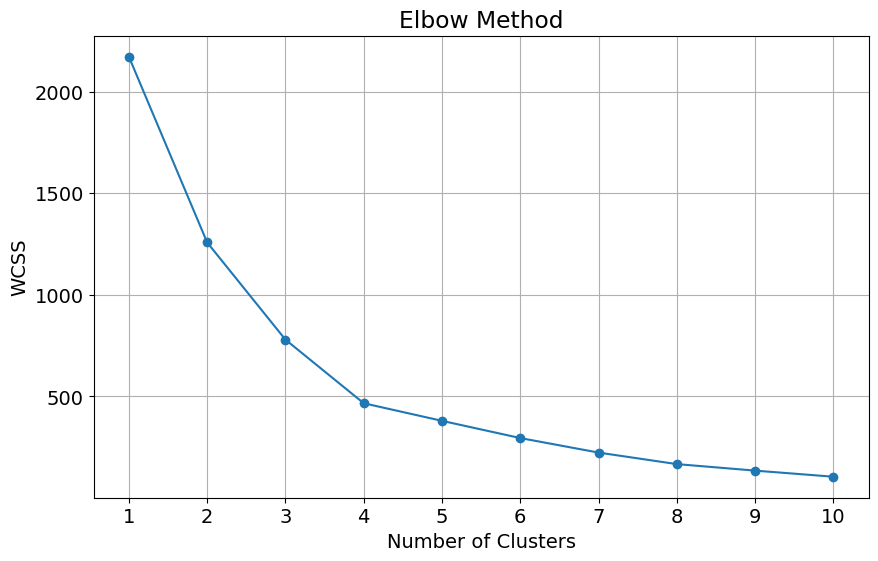

In [ ]:
prop_clustering = prop[['Floor_Category', 'Tipologia_Category']]  # Subset of columns for clustering

# Encoding categorical variables if needed
label_encoder = LabelEncoder()
for column in prop_clustering.columns:
    if prop_clustering[column].dtype == 'object':
        prop_clustering[column] = label_encoder.fit_transform(prop_clustering[column])

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(prop_clustering)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.title('Elbow Method')

plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(prop_clustering)

prop_clustering['Cluster'] = cluster_labels
prop['Cluster'] = cluster_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-524-3d4cc35e5c55>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_clustering['Cluster'] = cluster_labels


In [ ]:
prop

PropertyId   Região   Cidade          Bairro  Inativo  \
0              1   Lisboa   Lisboa  Santa Catarina        0   
1              2   Lisboa   Lisboa             NaN        1   
2              3   Lisboa   Lisboa             NaN        1   
3              4   Lisboa   Lisboa        S. Bento        1   
4              5   Lisboa   Lisboa             NaN        1   
...          ...      ...      ...             ...      ...   
1068        1796  Madeira  Funchal             NaN        0   
1069        1797  Madeira  Funchal             NaN        0   
1070        1798  Madeira  Funchal             NaN        0   
1071        1799  Madeira  Funchal             NaN        0   
1072        1800  Madeira  Funchal             NaN        0   

                 Data_Inicio Data_Inativo  ArCondicionado  MaqLoica  MaqRoupa  \
0    2014-08-05 00:00:00.000          NaT               1         1         1   
1    2014-03-18 00:00:00.000          NaT               0         0         0   
2    2013-10-22 00:00:00.000          NaT               0         0         0   
3    2013-11-28 00:00:00.000          NaT               0         1         1   
4    2013-11-12 00:00:00.000          NaT               0         0         0   
...                      ...          ...             ...       ...       ...   
1068 2021-09-11 10:00:27.669          NaT               1         1         1   
1069 2021-09-11 10:07:16.867          NaT               1         1         1   
1070 2021-09-11 10:11:53.426          NaT               1         1         1   
1071 2021-09-11 10:14:58.206          NaT               1         1         1   
1072 2021-09-11 10:18:12.468          NaT               1         1         1   

      Elevador Andar Tipologia  Duplex              Floor_Category  \
0          0.0   R/C        T2       0   Ground Floor and Basement   
1          1.0    1º         0       0   Lower Floors (1st to 3rd)   
2          1.0    5º         0       0  Middle Floors (4th to 7th)   
3          1.0    3º        T1       0   Lower Floors (1st to 3rd)   
4          0.0   R/C         0       0   Ground Floor and Basement   
...        ...   ...       ...     ...                         ...   
1068       1.0    2º        T0       0   Lower Floors (1st to 3rd)   
1069       1.0    2º        T1       0   Lower Floors (1st to 3rd)   
1070       1.0    2º        T1       0   Lower Floors (1st to 3rd)   
1071       1.0    3º        T1       0   Lower Floors (1st to 3rd)   
1072       1.0    3º        T1       0   Lower Floors (1st to 3rd)   

            Tipologia_Category  Cluster  
0     Small Apartments (T1-T2)        1  
1                      Unknown        3  
2                      Unknown        3  
3     Small Apartments (T1-T2)        2  
4                      Unknown        1  
...                        ...      ...  
1068          Studio/0-Bedroom        3  
1069  Small Apartments (T1-T2)        2  
1070  Small Apartments (T1-T2)        2  
1071  Small Apartments (T1-T2)        2  
1072  Small Apartments (T1-T2)        2  

[1073 rows x 17 columns]

In [ ]:
cluster_info = prop_clustering.groupby('Cluster').mean()
cluster_info

Floor_Category  Tipologia_Category
Cluster                                    
0              3.409692            1.594714
1              0.074257            2.193069
2              1.995789            1.814737
3              2.307692            3.621302

In [ ]:
prop['Cluster'].value_counts()

Cluster
2    475
0    227
1    202
3    169
Name: count, dtype: int64

In [ ]:
cluster_names = {
    0: 'Special Floor Large Apartments',
    1: 'Middle-Floor Medium Apartments',
    2: 'Ground-Level Small Apartments',
    3: 'Higher-Floor Large Apartments'
}

# Assign cluster names based on cluster numbers
prop['Cluster'] = prop['Cluster'].map(cluster_names)

In [ ]:
prop.isna().sum()

PropertyId              0
Região                  0
Cidade                  1
Bairro                430
Inativo                 0
Data_Inicio             0
Data_Inativo          836
ArCondicionado          0
MaqLoica                0
MaqRoupa                0
Elevador                0
Andar                   0
Tipologia               0
Duplex                  0
Floor_Category          0
Tipologia_Category      0
Cluster                 0
dtype: int64

In [ ]:
prop_map = dict(zip(prop['PropertyId'], prop['Cluster']))

# Create a new column 'Cluster' in 'res' by looking up Cluster based on PropertyId
res['Cluster'] = res['PropertyId'].map(prop_map)

In [ ]:
prop_map = dict(zip(res['ReservationId'], res['Cluster']))

# Create a new column 'Cluster' in 'res' by looking up Cluster based on PropertyId
data['Prop_Cluster'] = data['ReservationId'].map(prop_map)

In [ ]:
data

ReservationId  RatingValue  \
0         1879129551            8   
1         1879129551            8   
2         1879129551            8   
3         1879129551            8   
4         1879129551            8   
...              ...          ...   
12306     1879185160            4   
12307     1879185160            4   
12308     1879185160            4   
12309     1879185160            4   
12310     1879185160            4   

                                                Comments     Language  \
0      Un sitio agradable, lo mejor la terraza y las ...  __label__es   
1      Un sitio agradable, lo mejor la terraza y las ...  __label__es   
2      Un sitio agradable, lo mejor la terraza y las ...  __label__es   
3      Un sitio agradable, lo mejor la terraza y las ...  __label__es   
4      Un sitio agradable, lo mejor la terraza y las ...  __label__es   
...                                                  ...          ...   
12306  muito bom serviço de Feels Like Home mas o apa...  __label__pt   
12307  muito bom serviço de Feels Like Home mas o apa...  __label__pt   
12308  muito bom serviço de Feels Like Home mas o apa...  __label__pt   
12309  muito bom serviço de Feels Like Home mas o apa...  __label__pt   
12310  muito bom serviço de Feels Like Home mas o apa...  __label__pt   

                                              Translated  Polarity  \
0      pleasant site best part terrace view would per...  Positive   
1      pleasant site best part terrace view would per...  Positive   
2      pleasant site best part terrace view would per...  Positive   
3      pleasant site best part terrace view would per...  Positive   
4      pleasant site best part terrace view would per...  Positive   
...                                                  ...       ...   
12306  good feel like home service apartment disappoi...  Positive   
12307  good feel like home service apartment disappoi...  Positive   
12308  good feel like home service apartment disappoi...  Positive   
12309  good feel like home service apartment disappoi...  Positive   
12310  good feel like home service apartment disappoi...  Positive   

      NetPromoterScore        Aspects Aspects_Polarity  \
0                 Good           site         positive   
1                 Good   terrace view         positive   
2                 Good         faucet         negative   
3                 Good          blind         negative   
4                 Good          light          neutral   
...                ...            ...              ...   
12306             Good        service         positive   
12307             Good      apartment          neutral   
12308             Good      furniture         negative   
12309             Good         fridge         negative   
12310             Good  running water         negative   

                                          Aspect_vectors  \
0      [ 0.00871186  0.15052067  1.0032332  -0.076635...   
1      [ 3.2715511e-01 -1.2249010e+00 -1.5220459e+00 ...   
2      [-2.06883475e-01 -1.07614741e-01  1.58275709e-...   
3      [-0.23648827  0.11762756  0.30567795  0.188275...   
4      [-0.8753812  -1.6657984  -0.4803413   0.763185...   
...                                                  ...   
12306  [ 4.1551394e+00  3.3440182e-01  3.8822670e+00 ...   
12307  [-0.6586827  -0.49340886 -0.61936396  0.181167...   
12308  [ 0.47820753  0.3123826   0.75715965  2.262993...   
12309  [ 1.9406110e-01 -2.2963095e+00  9.8017961e-02 ...   
12310  [-0.9051482  -0.95062304  1.0281701  -0.180906...   

               Cluster_Labels reviewer_age_group reviewer_nationality  \
0      Accommodation Features              35-39                   ES   
1             Stay Experience              35-39                   ES   
2      Accommodation Features              35-39                   ES   
3      Accommodation Features              35-39                   ES   
4             Stay Experience              35-39             

<ipython-input-533-f3f9c3277647>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts_sorted.values, y=score_counts_sorted.index, palette=sns.color_palette("Dark2", len(score_counts_sorted)))


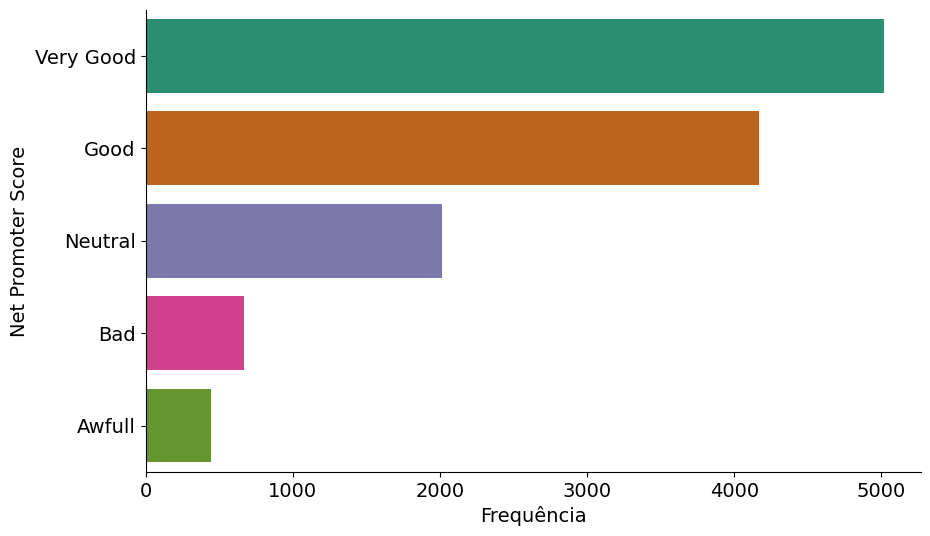

In [ ]:
# @title NetPromoterScore

score_counts = data['NetPromoterScore'].value_counts()

# Sort the scores based on frequency in descending order
score_counts_sorted = score_counts.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=score_counts_sorted.values, y=score_counts_sorted.index, palette=sns.color_palette("Dark2", len(score_counts_sorted)))
plt.title('')
plt.xlabel('Frequência')
plt.ylabel('Net Promoter Score')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
data['reviewer_nationality'].value_counts()

reviewer_nationality
FR    7141
ES    5167
Name: count, dtype: int64

In [ ]:
nps = ['Good','Very Good']
data = data[data['NetPromoterScore'].isin(nps)]

In [ ]:
data['NetPromoterScore'].value_counts()

NetPromoterScore
Very Good    5015
Good         4167
Name: count, dtype: int64

In [ ]:
len(data)

9182

#France

In [ ]:
france = data[data['reviewer_nationality'] == 'FR']
esp = data[data['reviewer_nationality'] == 'ES']
port = data[data['reviewer_nationality'] == 'PT']

## Distribuição de NPS

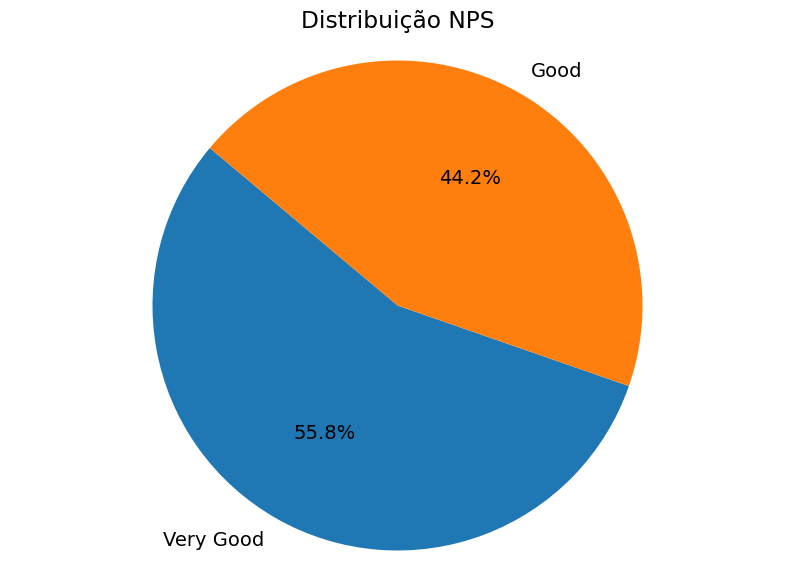

In [ ]:
nps_counts = france['NetPromoterScore'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 7))
plt.pie(nps_counts, labels=nps_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição NPS')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
france

ReservationId  RatingValue  \
5         1879130683            8   
6         1879130683            8   
7         1879130683            8   
8         1879130683            8   
9         1879130683            8   
...              ...          ...   
12306     1879185160            4   
12307     1879185160            4   
12308     1879185160            4   
12309     1879185160            4   
12310     1879185160            4   

                                                Comments     Language  \
5      Le logement est très très bien situé, propre d...  __label__fr   
6      Le logement est très très bien situé, propre d...  __label__fr   
7      Le logement est très très bien situé, propre d...  __label__fr   
8      Le logement est très très bien situé, propre d...  __label__fr   
9      Le logement est très très bien situé, propre d...  __label__fr   
...                                                  ...          ...   
12306  muito bom serviço de Feels Like Home mas o apa...  __label__pt   
12307  muito bom serviço de Feels Like Home mas o apa...  __label__pt   
12308  muito bom serviço de Feels Like Home mas o apa...  __label__pt   
12309  muito bom serviço de Feels Like Home mas o apa...  __label__pt   
12310  muito bom serviço de Feels Like Home mas o apa...  __label__pt   

                                              Translated  Polarity  \
5      accommodation well located clean overall also ...  Positive   
6      accommodation well located clean overall also ...  Positive   
7      accommodation well located clean overall also ...  Positive   
8      accommodation well located clean overall also ...  Positive   
9      accommodation well located clean overall also ...  Positive   
...                                                  ...       ...   
12306  good feel like home service apartment disappoi...  Positive   
12307  good feel like home service apartment disappoi...  Positive   
12308  good feel like home service apartment disappoi...  Positive   
12309  good feel like home service apartment disappoi...  Positive   
12310  good feel like home service apartment disappoi...  Positive   

      NetPromoterScore            Aspects Aspects_Polarity  \
5                 Good      accommodation         positive   
6                 Good           location         positive   
7                 Good  concierge service         positive   
8                 Good        cleanliness         positive   
9                 Good              space         positive   
...                ...                ...              ...   
12306             Good            service         positive   
12307             Good          apartment          neutral   
12308             Good          furniture         negative   
12309             Good             fridge         negative   
12310             Good      running water         negative   

                                          Aspect_vectors  \
5      [-0.05862487  0.00386601 -0.33326983  0.088091...   
6      [ 3.2019703   0.44487393 -2.1898077   0.115572...   
7      [ 2.2176492   0.7361839   2.2399268  -3.089105...   
8      [ 1.1196895   0.51563734  1.477156    0.946107...   
9      [-0.11217507 -1.3195558  -1.2931359  -0.874083...   
...                                                  ...   
12306  [ 4.1551394e+00  3.3440182e-01  3.8822670e+00 ...   
12307  [-0.6586827  -0.49340886 -0.61936396  0.181167...   
12308  [ 0.47820753  0.3123826   0.75715965  2.262993...   
12309  [ 1.9406110e-01 -2.2963095e+00  9.8017961e-02 ...   
12310  [-0.9051482  -0.95062304  1.0281701  -0.180906...   

               Cluster_Labels reviewer_age_group reviewer_nationality  \
5      Accommodation Features              45-49                   FR   
6                    Location              45-49                   FR   
7             Stay Experience              45-49                   FR   
8      Accommodation Features              45-49                   FR   
9            

<ipython-input-541-966b0861ff83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france['review_date'] = pd.to_datetime(france['review_date'])


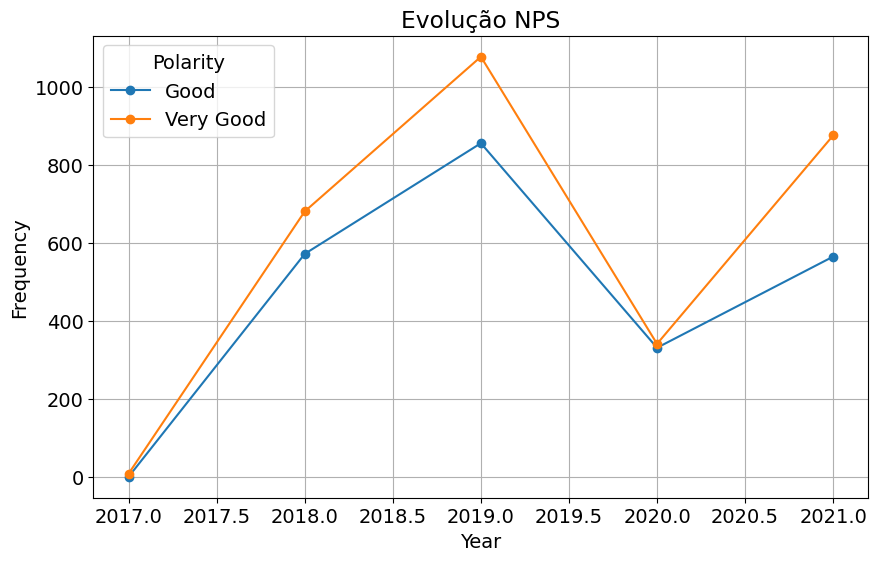

In [ ]:
france['review_date'] = pd.to_datetime(france['review_date'])

# Resample the data yearly and count the occurrences
yearly_data = france.groupby([france['review_date'].dt.year, 'NetPromoterScore']).size().unstack(fill_value=0)

# Plot
yearly_data.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Evolução NPS')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(title='Polarity')
plt.show()

In [ ]:
mask = np.array(Image.open(r"85c18d553c73c597f739e6f2f38c6d78.jpg"))

In [ ]:
comments = france['Aspects']
comments = france['Aspects'].dropna().astype(str)
all_comments = ' '.join(comments)

## Wordcloud


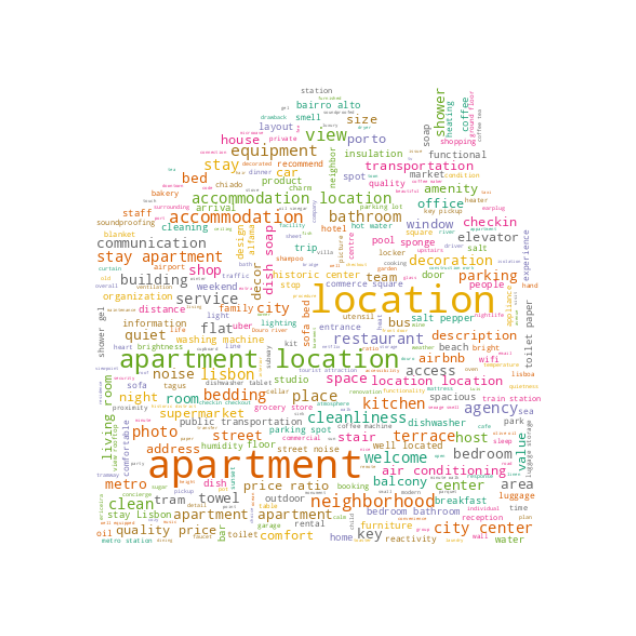

In [ ]:

wc = WordCloud(mask=mask, background_color="white",
               max_words=1000, max_font_size=1000,
               random_state=42, width=mask.shape[1]*2,
               height=mask.shape[0]*2,
               colormap='Dark2')  # Change to a darker colormap, e.g., 'Dark2'

wc.generate(all_comments)
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## Top 10 Aspectos e proporção NPS

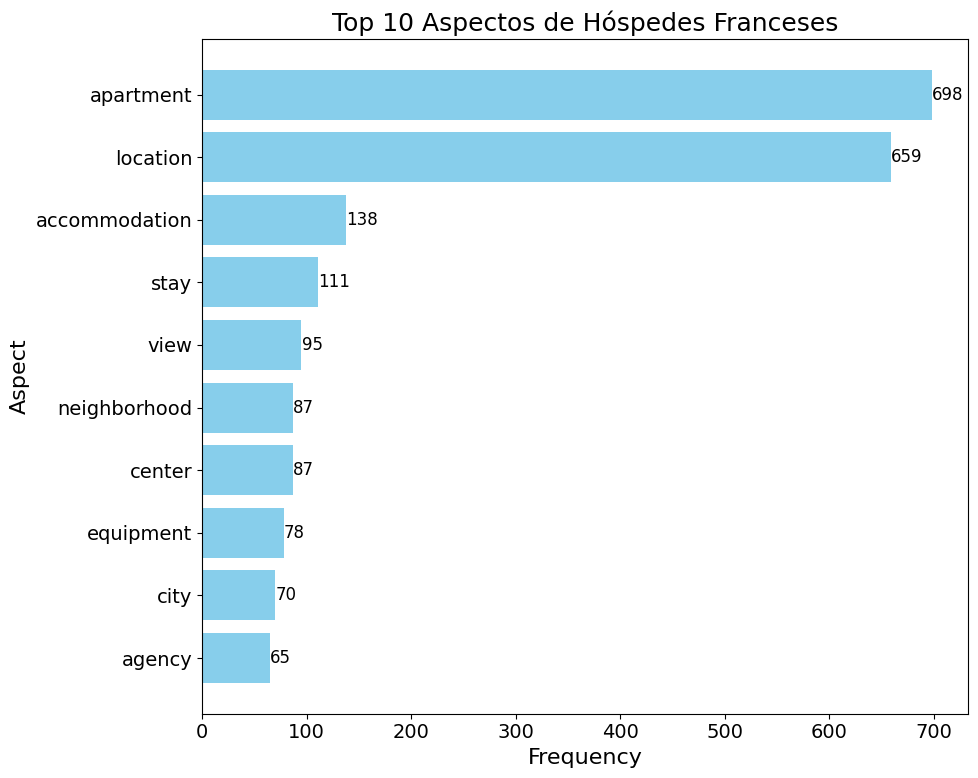

In [ ]:
all_aspects = ' '.join(france['Aspects']).split()

# Count occurrences of each aspect
aspect_counts = pd.Series(all_aspects).value_counts()

# Take top 15 aspects
top_15_aspects = aspect_counts.head(10)

# Sort aspects from lower to higher frequency
top_15_aspects = top_15_aspects.sort_values()

# Plotting
plt.figure(figsize=(10, 8))  # Adjust size to fit the plot nicely

# Create horizontal bar plot
bars = plt.barh(top_15_aspects.index, top_15_aspects, color='skyblue')

# Annotate each bar with its frequency
for bar in bars:
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}',
             va='center', ha='left', fontsize=12)

plt.title('Top 10 Aspectos de Hóspedes Franceses', fontsize=18)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Aspect', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

<ipython-input-546-3effc8459201>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france['NPS_Num'] = france['NetPromoterScore'].map(nps_mapping)


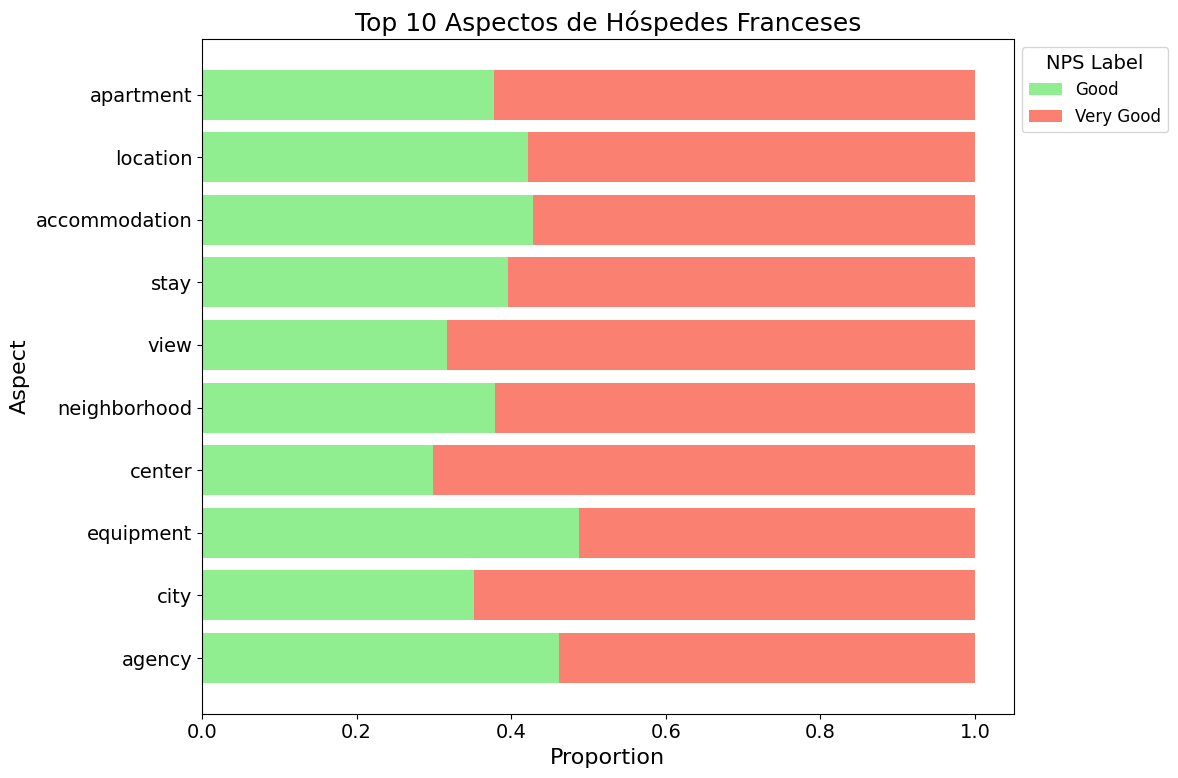

In [ ]:
nps_mapping = {'Neutral': 0, 'Good': 1, 'Very Good': 2}
france['NPS_Num'] = france['NetPromoterScore'].map(nps_mapping)

# Combine all aspects into a single string and split into individual aspects
all_aspects = ' '.join(france['Aspects']).split()

# Count occurrences of each aspect
aspect_counts = pd.Series(all_aspects).value_counts()

# Take top 10 aspects
top_10_aspects = aspect_counts.head(10)

# Sort aspects from lower to higher frequency
top_10_aspects = top_10_aspects.sort_values()

# Calculate the proportion of each NPS category for the top 10 aspects
aspect_nps_proportion = {}
for aspect in top_10_aspects.index:
    aspect_reviews = france[france['Aspects'].str.contains(re.escape(aspect))]
    nps_counts = aspect_reviews['NetPromoterScore'].value_counts(normalize=True)
    nps_proportion = {'Neutral': 0, 'Good': 0, 'Very Good': 0}
    for nps_label, proportion in nps_counts.items():
        nps_proportion[nps_label] = proportion
    aspect_nps_proportion[aspect] = nps_proportion

# Define NPS labels and colors
nps_labels = ['Good', 'Very Good']
nps_colors = ['lightgreen', 'salmon']

# Plotting
plt.figure(figsize=(12, 8))

# Create stacked bar plot for each aspect
for i, aspect in enumerate(top_10_aspects.index):
    bottom_value = 0
    for j, label in enumerate(nps_labels):
        nps_proportion = aspect_nps_proportion[aspect][label]
        plt.barh(i, nps_proportion, color=nps_colors[j], label=label if i == 0 else "", left=bottom_value)
        bottom_value += nps_proportion

plt.title('Top 10 Aspectos de Hóspedes Franceses', fontsize=18)
plt.xlabel('Proportion', fontsize=16)
plt.ylabel('Aspect', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(range(len(top_10_aspects.index)), top_10_aspects.index, fontsize=14)
plt.legend(title='NPS Label', bbox_to_anchor=(1, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.tight_layout()

plt.show()

## Top 10 bigramas e proporção NPS

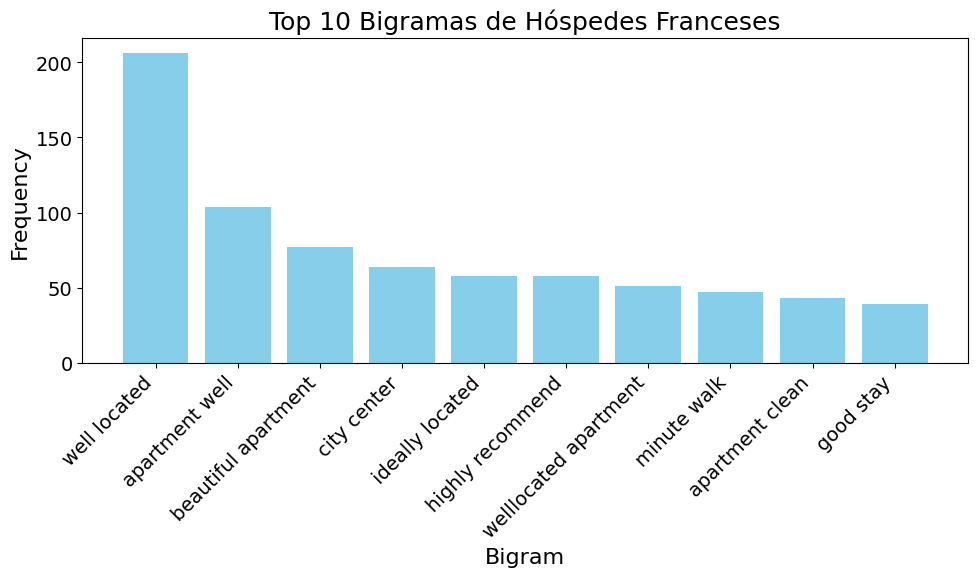

In [ ]:
france_unique_reviews = france.drop_duplicates(subset='ReservationId', keep='first')

# Tokenize the translated reviews
all_reviews = ' '.join(france_unique_reviews['Translated'])
tokens = word_tokenize(all_reviews)

# Create bigrams
bigram_list = list(bigrams(tokens))

# Filter out specific bigrams
filtered_bigrams = [bigram for bigram in bigram_list if bigram not in [('like', 'home'), ('feel', 'like')]]

# Count occurrences of each bigram
bigram_counts = Counter(filtered_bigrams)

# Get the top N bigrams
top_n_bigrams = bigram_counts.most_common(10)

# Extract bigrams and their frequencies
bigrams_top, frequencies = zip(*top_n_bigrams)

# Plotting
plt.figure(figsize=(10, 6))

# Create bar plot for the top bigrams
plt.bar([f"{bigram[0]} {bigram[1]}" for bigram in bigrams_top], frequencies, color='skyblue')
plt.title('Top 10 Bigramas de Hóspedes Franceses', fontsize=18)
plt.xlabel('Bigram', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

plt.show()

<ipython-input-548-6af36d49de3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france['NPS_Num'] = france['NetPromoterScore'].map(nps_mapping)


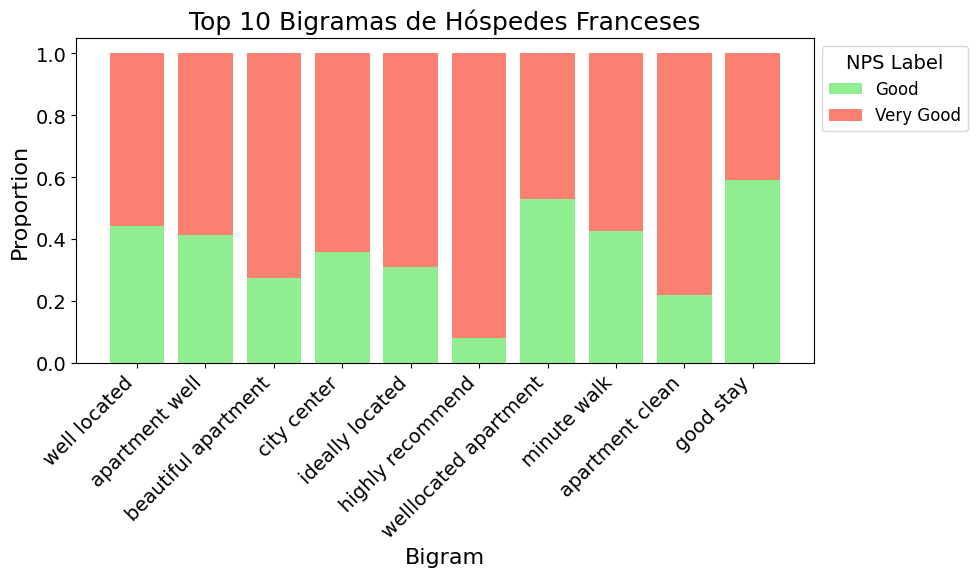

In [ ]:
nps_mapping = {'Neutral': 0, 'Good': 1, 'Very Good': 2}
france['NPS_Num'] = france['NetPromoterScore'].map(nps_mapping)

# Filter out repeated ReservationId and keep only the first review associated with each unique ReservationId
france_unique_reviews = france.drop_duplicates(subset='ReservationId', keep='first')

# Tokenize the translated reviews
all_reviews = ' '.join(france_unique_reviews['Translated'])
tokens = word_tokenize(all_reviews)

# Create bigrams
bigram_list = list(bigrams(tokens))

# Filter out specific bigrams
filtered_bigrams = [bigram for bigram in bigram_list if bigram not in [('like', 'home'), ('feel', 'like')]]

# Calculate the proportion of each category of NPS for each bigram
bigram_nps_proportion = {}
for bigram in filtered_bigrams:
    bigram_reviews = france_unique_reviews[france_unique_reviews['Translated'].str.contains(re.escape(' '.join(bigram)))]
    nps_counts = bigram_reviews['NetPromoterScore'].value_counts(normalize=True)
    nps_proportion = {'Neutral': 0, 'Good': 0, 'Very Good': 0}
    for nps_label, proportion in nps_counts.items():
        nps_proportion[nps_label] = proportion
    bigram_nps_proportion[bigram] = nps_proportion

# Count occurrences of each bigram
bigram_counts = Counter(filtered_bigrams)

# Get the top N bigrams
top_n_bigrams = bigram_counts.most_common(10)  # Change 10 to your desired number of top bigrams

# Extract bigrams and their frequencies
bigrams_top, frequencies = zip(*top_n_bigrams)

# Define NPS labels and colors
nps_labels = ['Good', 'Very Good']
nps_colors = ['lightgreen', 'salmon']

# Plotting
plt.figure(figsize=(10, 6))

# Create stacked bar plot for each bigram
for i, bigram in enumerate(bigrams_top):
    for j, label in enumerate(nps_labels):
        nps_proportion = bigram_nps_proportion[bigram][label]
        plt.bar(i, nps_proportion, color=nps_colors[j], label=label if i == 0 else None, bottom=sum(bigram_nps_proportion[bigram][nps_labels[k]] for k in range(j)))

plt.title('Top 10 Bigramas de Hóspedes Franceses', fontsize=18)
plt.xlabel('Bigram', fontsize=16)
plt.ylabel('Proportion', fontsize=16)
plt.xticks(range(len(bigrams_top)), [f"{bigram[0]} {bigram[1]}" for bigram in bigrams_top], rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='NPS Label', bbox_to_anchor=(1, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.tight_layout()

plt.show()

## Clusters count e proporção NPS


In [ ]:
france.head(1)

ReservationId  RatingValue  \
5     1879130683            8   

                                            Comments     Language  \
5  Le logement est très très bien situé, propre d...  __label__fr   

                                          Translated  Polarity  \
5  accommodation well located clean overall also ...  Positive   

  NetPromoterScore        Aspects Aspects_Polarity  \
5             Good  accommodation         positive   

                                      Aspect_vectors          Cluster_Labels  \
5  [-0.05862487  0.00386601 -0.33326983  0.088091...  Accommodation Features   

  reviewer_age_group reviewer_nationality review_date  valor_reserva  \
5              45-49                   FR  2020-10-29          124.1   

                    Prop_Cluster  NPS_Num  
5  Ground-Level Small Apartments        1

<ipython-input-550-d7d6a8653a33>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=france, y='Cluster_Labels', x=france.groupby('Cluster_Labels').transform('count').iloc[:, 0], palette='Set3', orient='h')


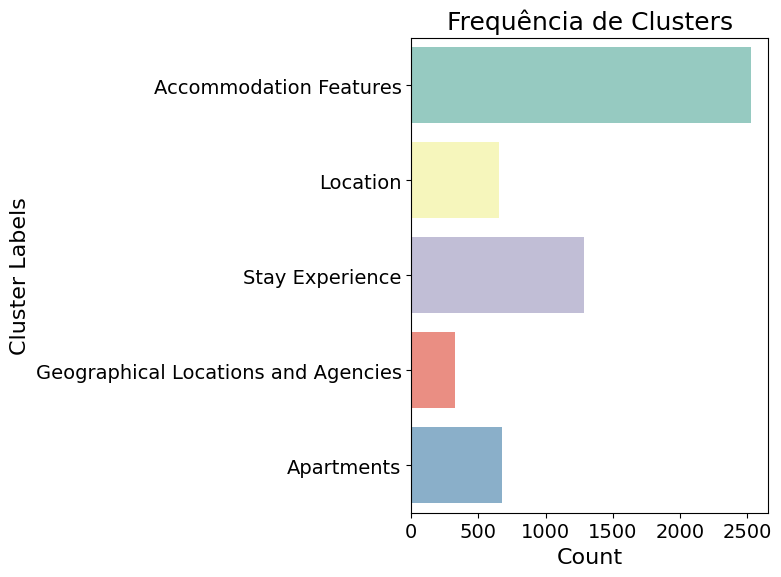

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=france, y='Cluster_Labels', x=france.groupby('Cluster_Labels').transform('count').iloc[:, 0], palette='Set3', orient='h')
plt.title('Frequência de Clusters', fontsize=18)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Cluster Labels', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(rotation=0, fontsize=14)  # Ensure y-ticks are not rotated
plt.tight_layout()
plt.show()

Counts of each NPS category per cluster:
NetPromoterScore                     Neutral  Good  Very Good
Cluster_Labels                                               
Accommodation Features                     0  1183       1345
Apartments                                 0   254        420
Geographical Locations and Agencies        0   131        196
Location                                   0   274        378
Stay Experience                            0   576        711

Proportions of each NPS category per cluster:
NetPromoterScore                     Neutral      Good  Very Good
Cluster_Labels                                                   
Accommodation Features                   0.0  0.467959   0.532041
Apartments                               0.0  0.376855   0.623145
Geographical Locations and Agencies      0.0  0.400612   0.599388
Location                                 0.0  0.420245   0.579755
Stay Experience                          0.0  0.447552   0.552448


<Figure size 1200x800 with 0 Axes>

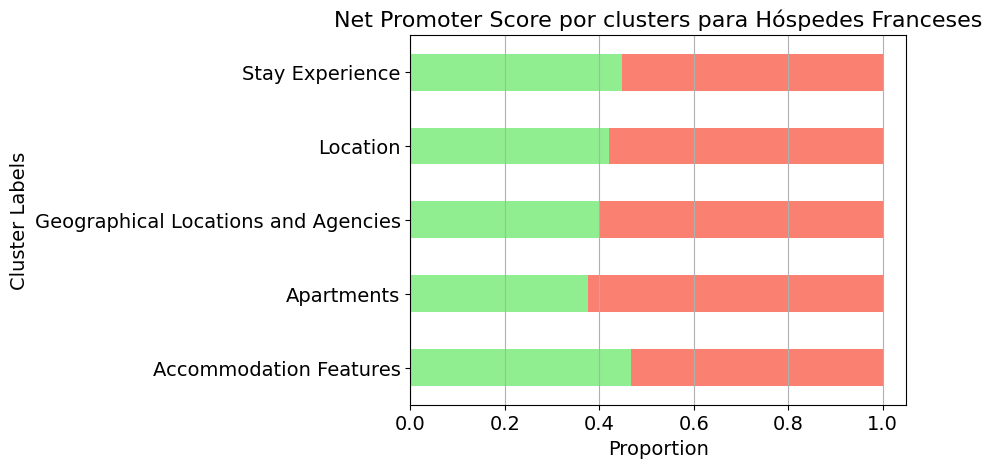

In [ ]:
nps_labels = ['Neutral', 'Good', 'Very Good']
nps_colors = ['skyblue', 'lightgreen', 'salmon']

# Calculate counts of each NPS category per cluster
cluster_nps_counts = france.groupby(['Cluster_Labels', 'NetPromoterScore']).size().unstack(fill_value=0)

# Ensure all NPS labels are present in the counts DataFrame
for label in nps_labels:
    if label not in cluster_nps_counts.columns:
        cluster_nps_counts[label] = 0

# Reorder columns to match nps_labels order
cluster_nps_counts = cluster_nps_counts[nps_labels]

# Print counts for verification
print("Counts of each NPS category per cluster:")
print(cluster_nps_counts)

# Calculate proportions of each NPS category per cluster
cluster_nps_proportions = cluster_nps_counts.div(cluster_nps_counts.sum(axis=1), axis=0)

# Print proportions for verification
print("\nProportions of each NPS category per cluster:")
print(cluster_nps_proportions)

plt.rcParams.update({'font.size': 14})

# Plot stacked horizontal bar plot for proportions of NPS categories per cluster
plt.figure(figsize=(12, 8))  # Adjust figsize as needed
cluster_nps_proportions.plot(kind='barh', stacked=True, color=nps_colors, legend=False)
plt.title('Net Promoter Score por clusters para Hóspedes Franceses', fontsize=16)
plt.xlabel('Proportion')
plt.ylabel('Cluster Labels')
plt.yticks(rotation=0)  # Rotate y ticks if needed
plt.grid(axis='x')  # Add grid lines along x-axis for better readability
plt.show()

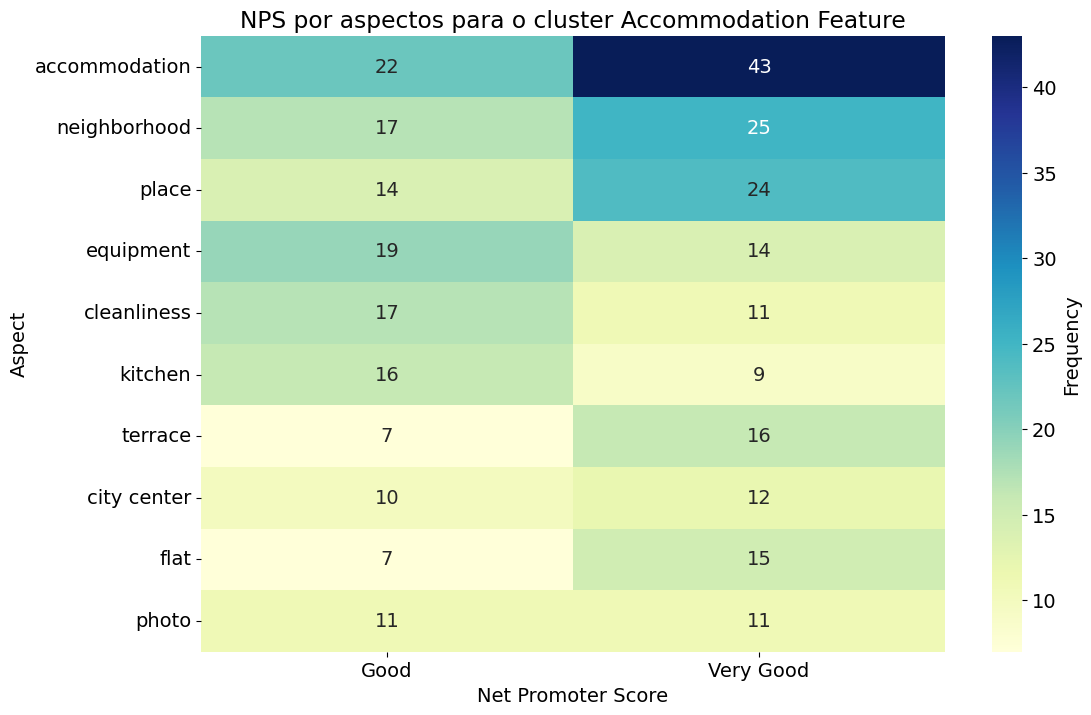

In [ ]:
filtered_data = france[(france['Cluster_Labels'] == 'Accommodation Features') &
                       (france['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]

# Counting the frequency of each aspect for each NetPromoterScore
aspect_nps_counts = filtered_data.pivot_table(index='Aspects', columns='NetPromoterScore', aggfunc='size', fill_value=0)

# Getting the top 10 most common aspects
top_aspects = aspect_nps_counts.sum(axis=1).nlargest(10).index

# Filtering the table to show only the top 10 aspects
top_aspect_nps_counts = aspect_nps_counts.loc[top_aspects]

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_aspect_nps_counts, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.title('NPS por aspectos para o cluster Accommodation Feature')
plt.xlabel('Net Promoter Score')
plt.ylabel('Aspect')
plt.show()

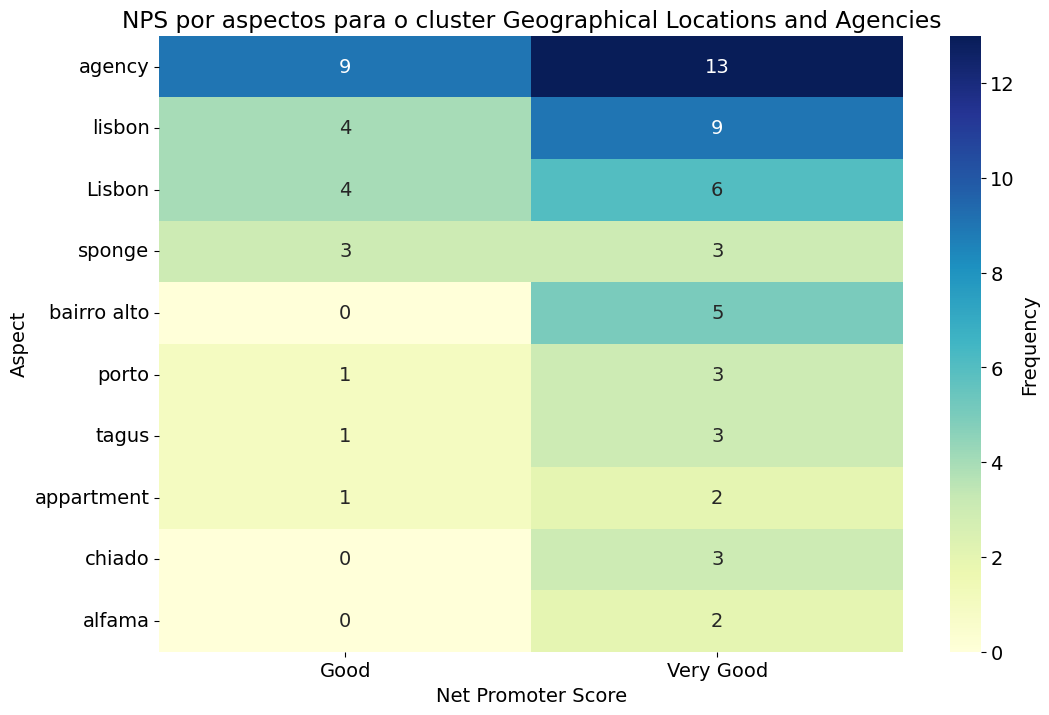

In [ ]:
filtered_data = france[(france['Cluster_Labels'] == 'Geographical Locations and Agencies') &
                       (france['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]

# Counting the frequency of each aspect for each NetPromoterScore
aspect_nps_counts = filtered_data.pivot_table(index='Aspects', columns='NetPromoterScore', aggfunc='size', fill_value=0)

# Getting the top 10 most common aspects
top_aspects = aspect_nps_counts.sum(axis=1).nlargest(10).index

# Filtering the table to show only the top 10 aspects
top_aspect_nps_counts = aspect_nps_counts.loc[top_aspects]

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_aspect_nps_counts, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.title('NPS por aspectos para o cluster Geographical Locations and Agencies')
plt.xlabel('Net Promoter Score')
plt.ylabel('Aspect')
plt.show()

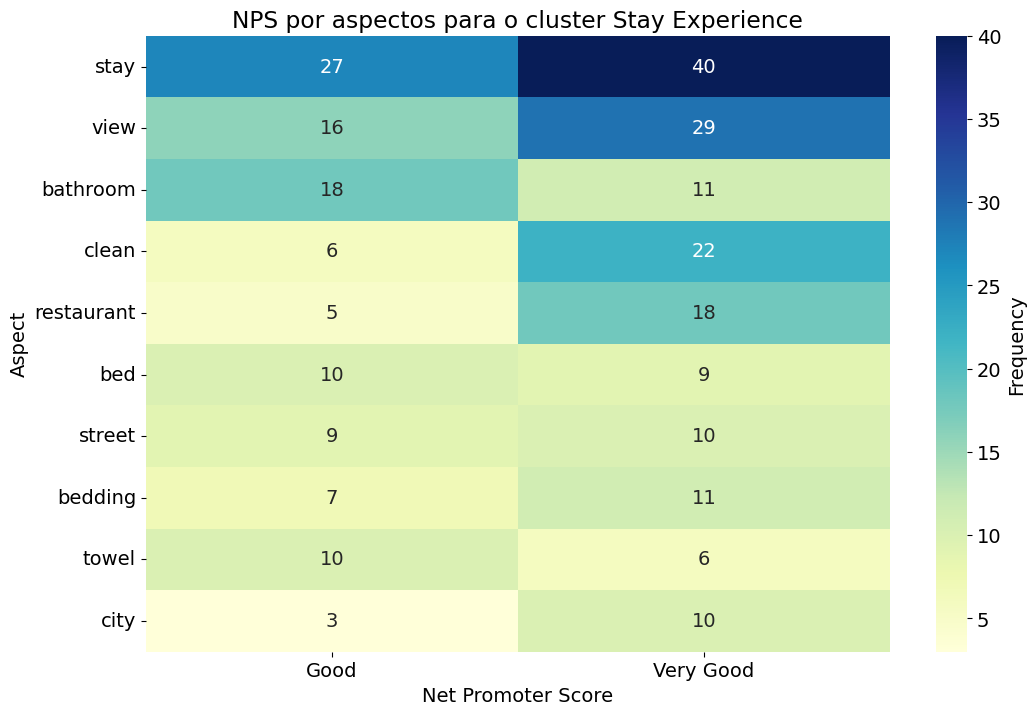

In [ ]:
filtered_data = france[(france['Cluster_Labels'] == 'Stay Experience') &
                       (france['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]

# Counting the frequency of each aspect for each NetPromoterScore
aspect_nps_counts = filtered_data.pivot_table(index='Aspects', columns='NetPromoterScore', aggfunc='size', fill_value=0)

# Getting the top 10 most common aspects
top_aspects = aspect_nps_counts.sum(axis=1).nlargest(10).index

# Filtering the table to show only the top 10 aspects
top_aspect_nps_counts = aspect_nps_counts.loc[top_aspects]

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_aspect_nps_counts, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.title('NPS por aspectos para o cluster Stay Experience')
plt.xlabel('Net Promoter Score')
plt.ylabel('Aspect')
plt.show()

In [ ]:
aspects = ['clean','cleanliness','bathroom','view','tagus','equipment','kitchen']

# Initialize an empty list to store results for 'Good' NPS
all_results_good = []

# Initialize an empty list to store results for 'Very Good' NPS
all_results_very_good = []

# Iterate over each aspect
for aspect in aspects:
    # Filtered data for 'Good' NPS
    filtered_data_good = france[(france['Aspects'] == aspect) &
                            (france['NetPromoterScore'] == 'Good') &
                            (france['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]['Translated']

    # Create a list to store words that appear before the aspect in each sentence for 'Good' NPS
    before_words_good = []

    # Extract words that appear before the aspect in each sentence for 'Good' NPS
    for sentence in filtered_data_good:
        words = sentence.split()
        for i in range(1, len(words)):
            if words[i].lower() == aspect:
                if i > 0:
                    before_words_good.append(words[i-1].lower())

    # Count the frequency of each word for 'Good' NPS
    word_counts_good = pd.Series(before_words_good).value_counts().head(3)

    # Create a dictionary to store the results for 'Good' NPS for the current aspect
    results_good = {
        'Aspect': aspect,
        'Most Frequent Opinion': list(word_counts_good.index)
    }

    # Append results to the list for 'Good' NPS
    all_results_good.append(results_good)

    # Filtered data for 'Very Good' NPS
    filtered_data_very_good = france[(france['Aspects'] == aspect) &
                                  (france['NetPromoterScore'] == 'Very Good') &
                                  (france['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]['Translated']

    # Create a list to store words that appear before the aspect in each sentence for 'Very Good' NPS
    before_words_very_good = []

    # Extract words that appear before the aspect in each sentence for 'Very Good' NPS
    for sentence in filtered_data_very_good:
        words = sentence.split()
        for i in range(1, len(words)):
            if words[i].lower() == aspect:
                if i > 0:
                    before_words_very_good.append(words[i-1].lower())

    # Count the frequency of each word for 'Very Good' NPS
    word_counts_very_good = pd.Series(before_words_very_good).value_counts().head(3)

    # Create a dictionary to store the results for 'Very Good' NPS for the current aspect
    results_very_good = {
        'Aspect': aspect,
        'Most Frequent Opinion': list(word_counts_very_good.index)
    }

    # Append results to the list for 'Very Good' NPS
    all_results_very_good.append(results_very_good)

# Create DataFrames from the lists of results for 'Good' and 'Very Good' NPS
df_results_good = pd.DataFrame(all_results_good)
df_results_very_good = pd.DataFrame(all_results_very_good)

In [ ]:
df_results_good

Aspect           Most Frequent Opinion
0        clean             [view, square, key]
1  cleanliness     [lacked, doubtful, average]
2     bathroom           [one, small, machine]
3         view  [beautiful, magnificent, nice]
4        tagus                          [view]
5    equipment      [lack, malfunction, basic]
6      kitchen      [especially, ant, hallway]

In [ ]:
df_results_very_good

Aspect           Most Frequent Opinion
0        clean     [apartment, nice, location]
1  cleanliness   [perfect, beautiful, someone]
2     bathroom     [spacious, luxury, bedding]
3         view  [magnificent, nice, beautiful]
4        tagus             [view, close, next]
5    equipment         [necessary, good, term]
6      kitchen       [instance, centre, stuff]

## Evolução de clusters ao longo do tempo

In [ ]:
france.isna().sum()

ReservationId             0
RatingValue               0
Comments                  0
Language                  0
Translated                0
Polarity                  0
NetPromoterScore          0
Aspects                   0
Aspects_Polarity          0
Aspect_vectors            0
Cluster_Labels            0
reviewer_age_group        0
reviewer_nationality      0
review_date             160
valor_reserva           174
Prop_Cluster            174
NPS_Num                   0
dtype: int64

In [ ]:
france.columns

Index(['ReservationId', 'RatingValue', 'Comments', 'Language', 'Translated',
       'Polarity', 'NetPromoterScore', 'Aspects', 'Aspects_Polarity',
       'Aspect_vectors', 'Cluster_Labels', 'reviewer_age_group',
       'reviewer_nationality', 'review_date', 'valor_reserva', 'Prop_Cluster',
       'NPS_Num'],
      dtype='object')

<ipython-input-560-7b349f5efa0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france.dropna(subset=['review_date'], inplace=True)
<ipython-input-560-7b349f5efa0c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france['review_date'] = pd.to_datetime(france['review_date'])


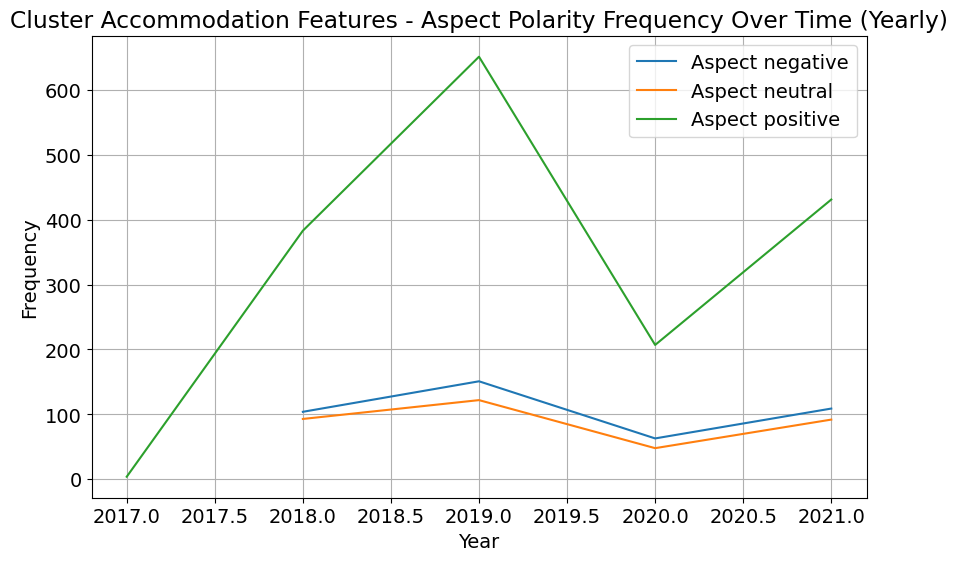

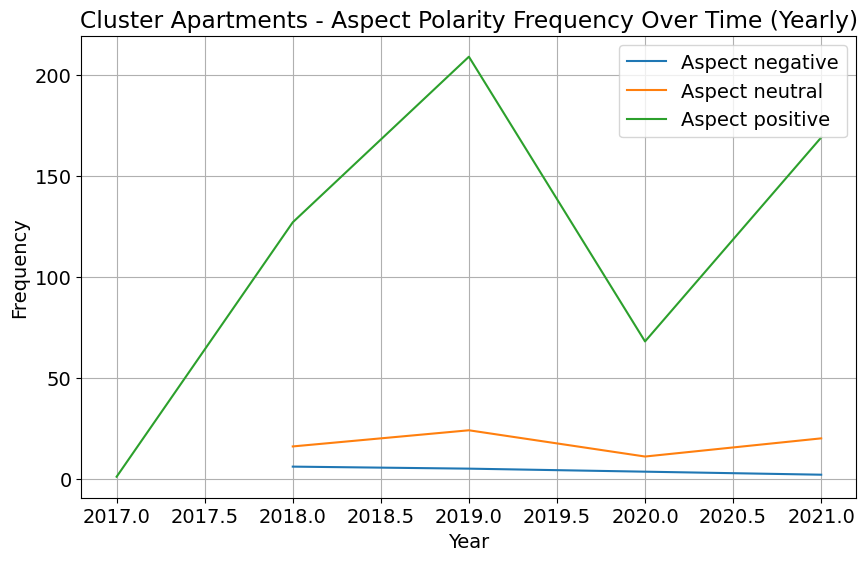

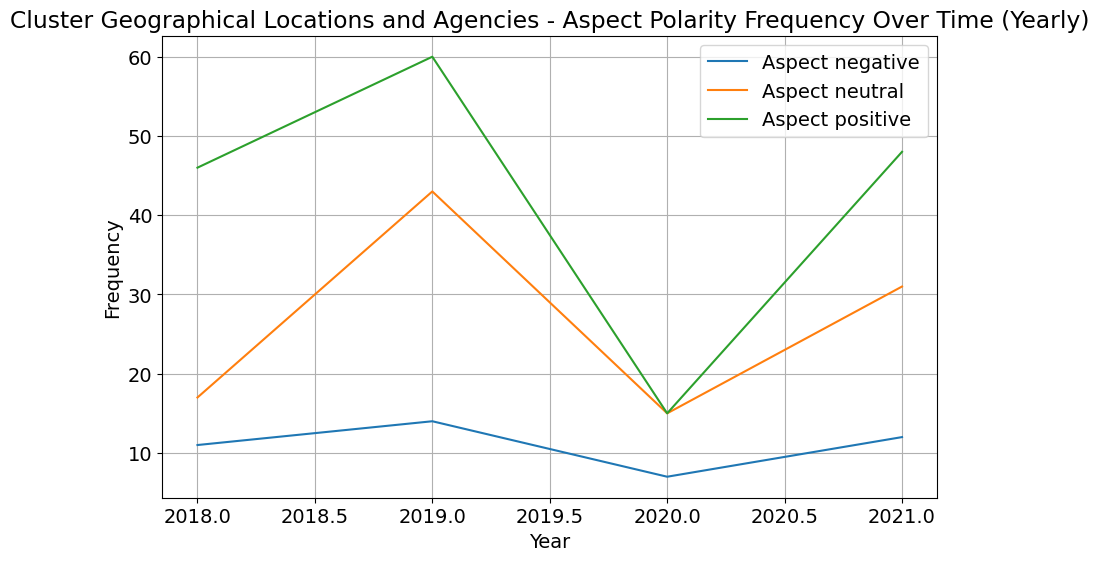

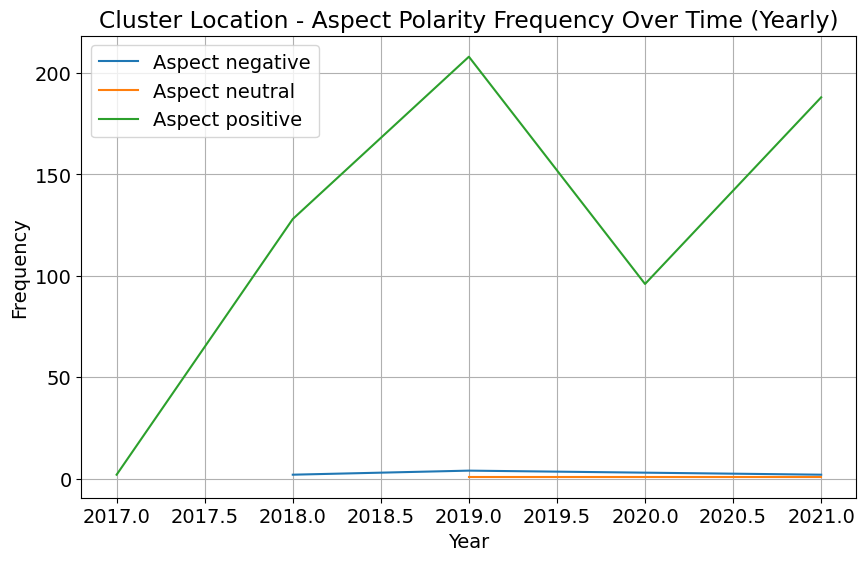

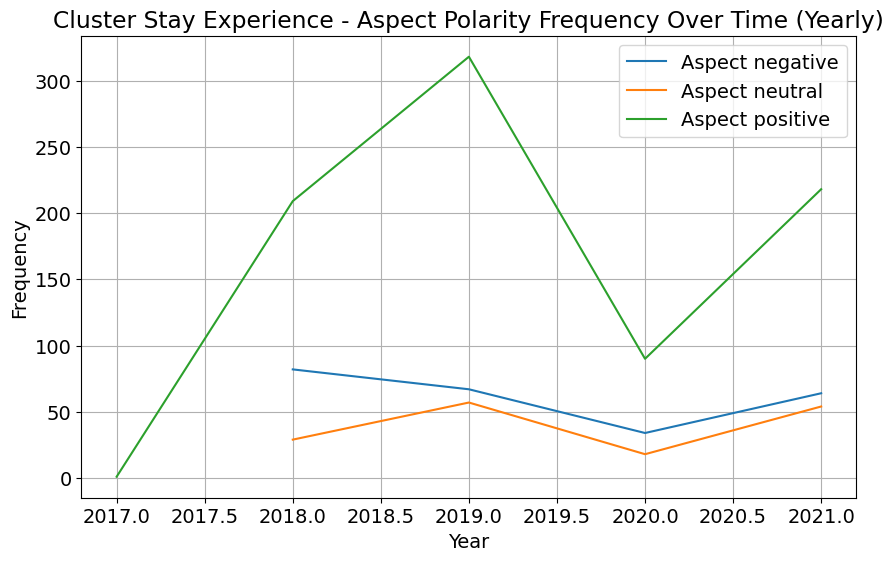

In [ ]:
france.dropna(subset=['review_date'], inplace=True)

# Convert 'review_date' to datetime if it's not already
france['review_date'] = pd.to_datetime(france['review_date'])

# Group the data by 'Cluster_Labels'
grouped_data = france.groupby('Cluster_Labels')

# Iterate over the groups, plotting the frequency of aspect polarity values yearly for each cluster
for group_name, group_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.title(f'Cluster {group_name} - Aspect Polarity Frequency Over Time (Yearly)')
    for aspect, aspect_data in group_data.groupby('Aspects_Polarity'):
        aspect_freq_yearly = aspect_data.groupby(aspect_data['review_date'].dt.year).size()
        plt.plot(aspect_freq_yearly.index, aspect_freq_yearly.values, label=f'Aspect {aspect}')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

<ipython-input-561-9b771a2565bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france.dropna(subset=['review_date'], inplace=True)
<ipython-input-561-9b771a2565bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france['review_date'] = pd.to_datetime(france['review_date'])


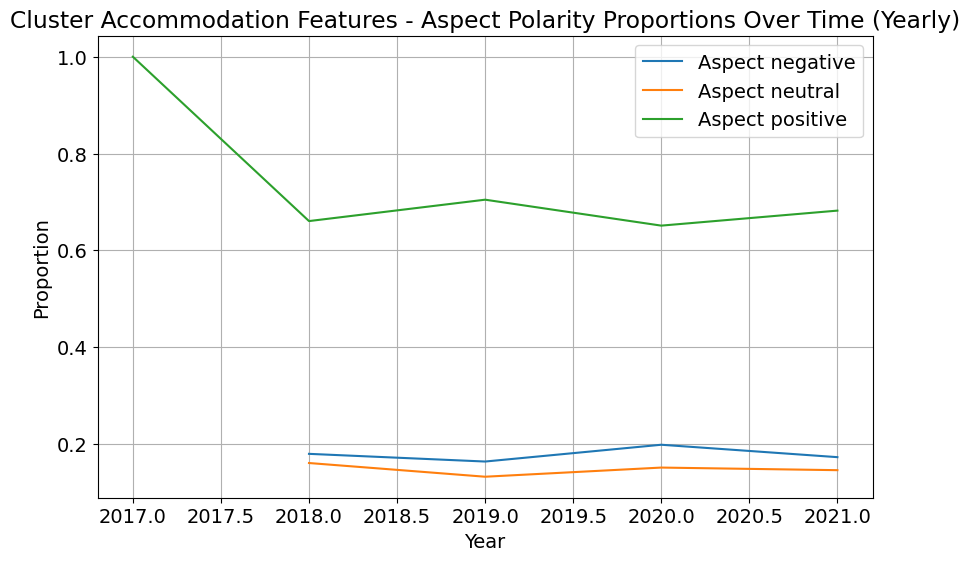

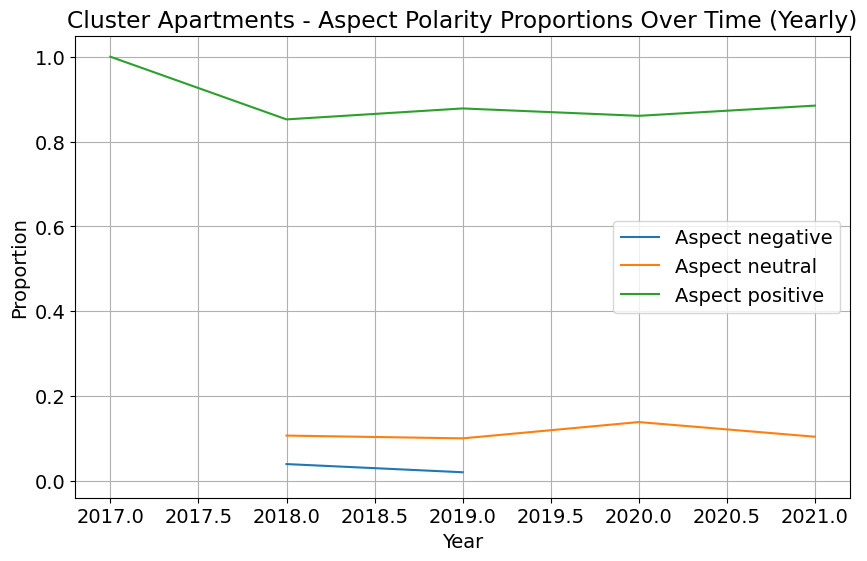

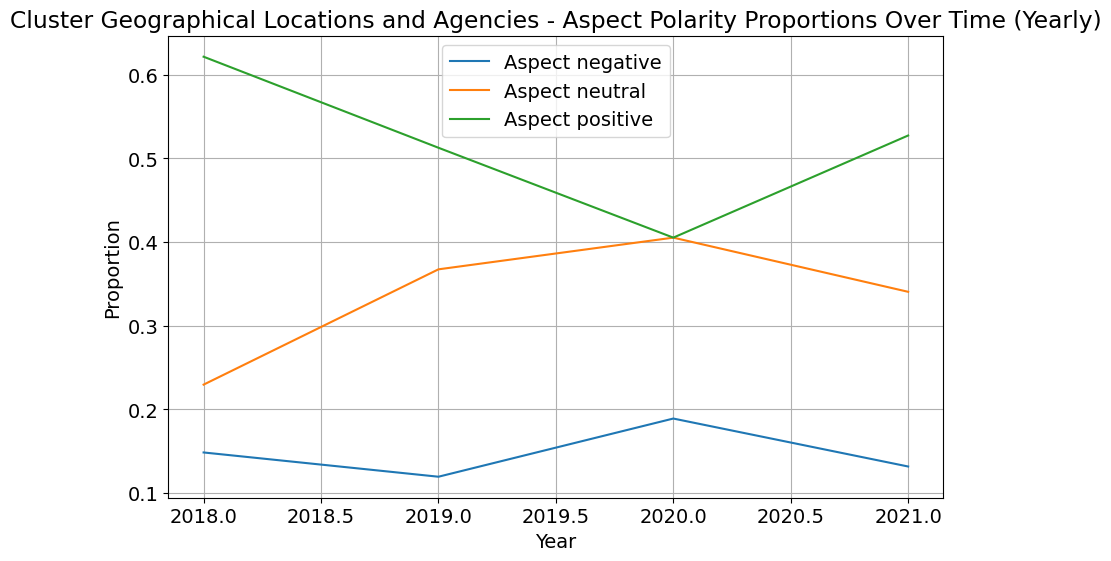

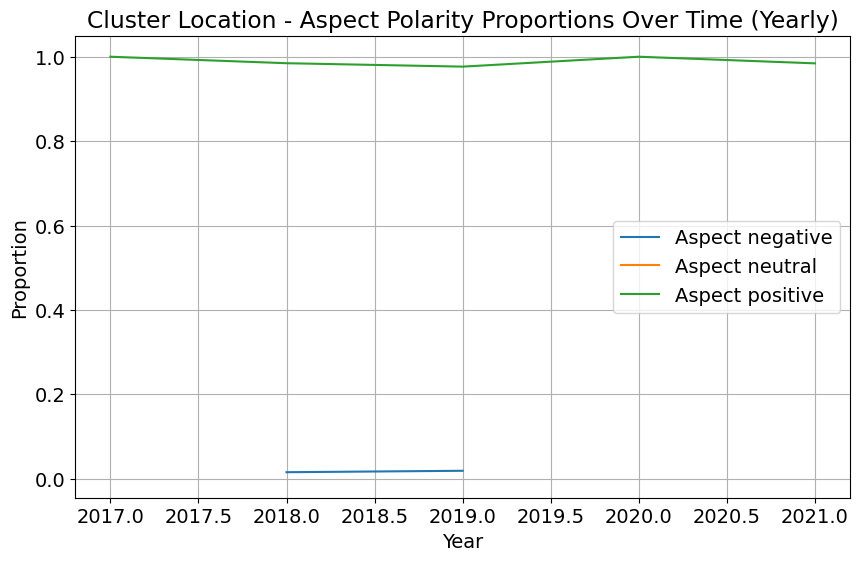

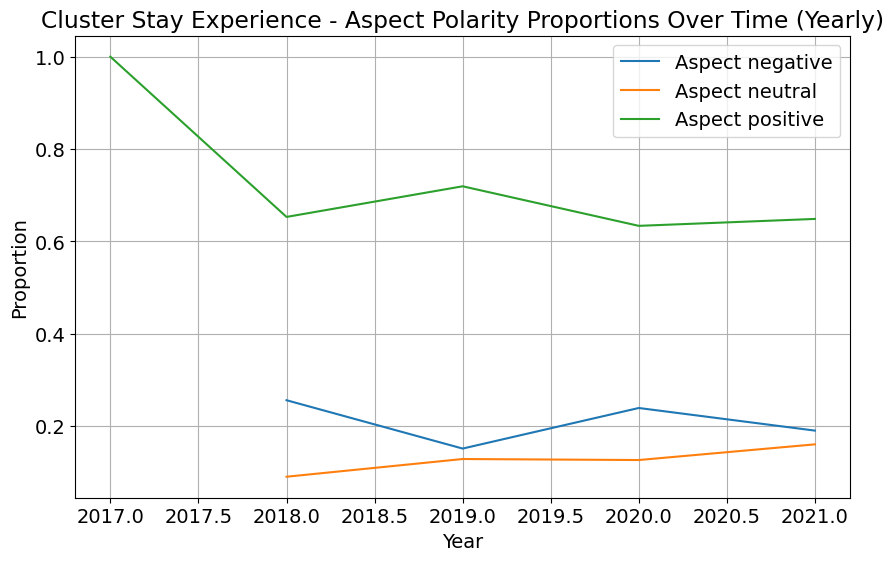

In [ ]:
france.dropna(subset=['review_date'], inplace=True)

# Convert 'review_date' to datetime if it's not already
france['review_date'] = pd.to_datetime(france['review_date'])

# Group the data by 'Cluster_Labels'
grouped_data = france.groupby('Cluster_Labels')

# Iterate over the groups, plotting the proportions of aspect polarity values yearly for each cluster
for group_name, group_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.title(f'Cluster {group_name} - Aspect Polarity Proportions Over Time (Yearly)')
    for aspect, aspect_data in group_data.groupby('Aspects_Polarity'):
        aspect_count_yearly = aspect_data.groupby(aspect_data['review_date'].dt.year).size()
        total_reviews_yearly = group_data['review_date'].dt.year.value_counts()
        aspect_proportions_yearly = aspect_count_yearly.div(total_reviews_yearly)
        plt.plot(aspect_proportions_yearly.index, aspect_proportions_yearly.values, label=f'Aspect {aspect}')
    plt.xlabel('Year')
    plt.ylabel('Proportion')
    plt.legend()
    plt.grid(True)
    plt.show()

## Análise relativa a faixa etária

In [ ]:
age_group_counts = france['reviewer_age_group'].value_counts()
top_2_age_groups = age_group_counts.head(3).index.tolist()
print("Top 2 Age Groups:", top_2_age_groups)

Top 2 Age Groups: ['25-29', '30-34', '35-39']


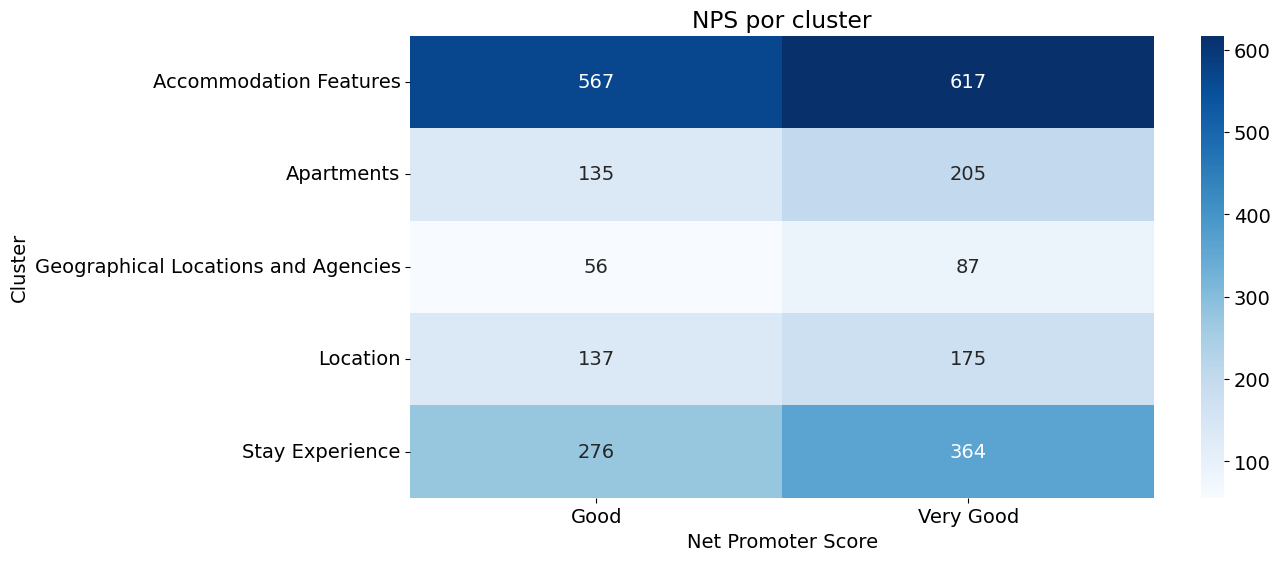

In [ ]:
selected_age_groups = ['25-29', '30-34', '35-39']

plt.rcParams.update({'font.size': 14})

# Filter the DataFrame for the selected age groups
selected_age_df = france[france['reviewer_age_group'].isin(selected_age_groups)]

# Group by cluster and Net Promoter Score and count the values
heatmap_data = selected_age_df.groupby(['Cluster_Labels', 'NetPromoterScore']).size().unstack(fill_value=0)

# Reorder the columns to preserve the original order
heatmap_data = heatmap_data[['Good', 'Very Good']]

# Plot the Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
plt.title('NPS por cluster')
plt.xlabel('Net Promoter Score')
plt.ylabel('Cluster')
plt.show()

## Análise relative a tipo de propriedades

<ipython-input-564-b1ed89a31e6f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=france, y='Prop_Cluster', x=france.groupby('Prop_Cluster').transform('count').iloc[:, 0], palette='Set3', orient='h')


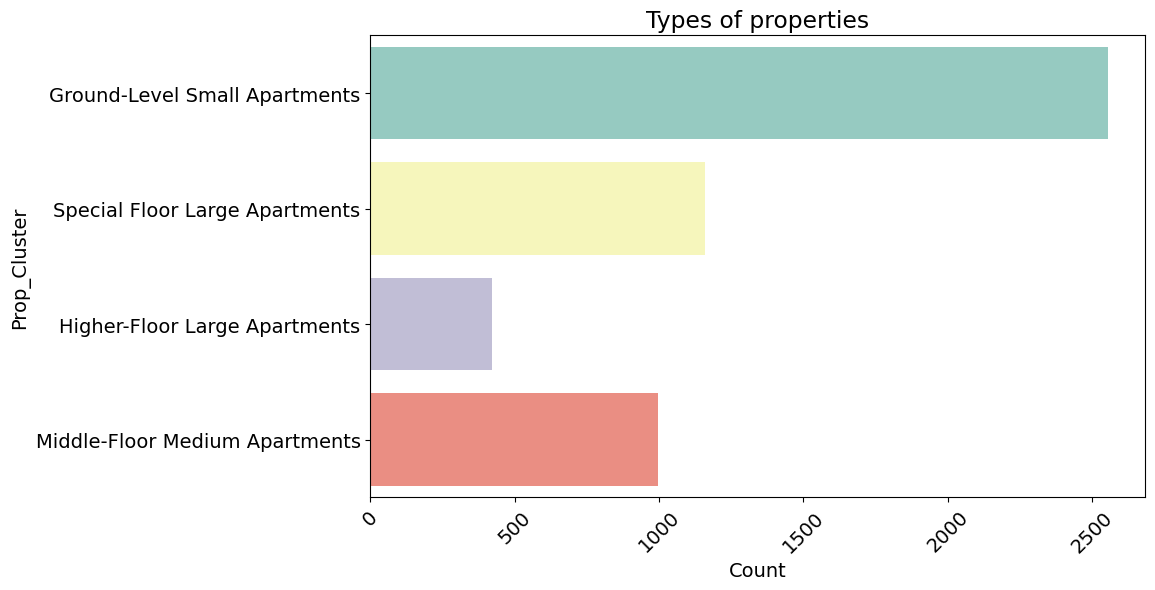

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=france, y='Prop_Cluster', x=france.groupby('Prop_Cluster').transform('count').iloc[:, 0], palette='Set3', orient='h')
plt.title('Types of properties')
plt.xlabel('Count')
plt.ylabel('Prop_Cluster')
plt.xticks(rotation=45)  # Rotate x-labels for better readability if necessary
plt.show()


Counts of each NPS category per Prop_Cluster:
NetPromoterScore                Neutral  Good  Very Good
Prop_Cluster                                            
Ground-Level Small Apartments         0  1117       1439
Higher-Floor Large Apartments         0   229        194
Middle-Floor Medium Apartments        0   496        501
Special Floor Large Apartments        0   435        723

Proportions of each NPS category per Prop_Cluster:
NetPromoterScore                Neutral      Good  Very Good
Prop_Cluster                                                
Ground-Level Small Apartments       0.0  0.437011   0.562989
Higher-Floor Large Apartments       0.0  0.541371   0.458629
Middle-Floor Medium Apartments      0.0  0.497492   0.502508
Special Floor Large Apartments      0.0  0.375648   0.624352


<Figure size 1200x600 with 0 Axes>

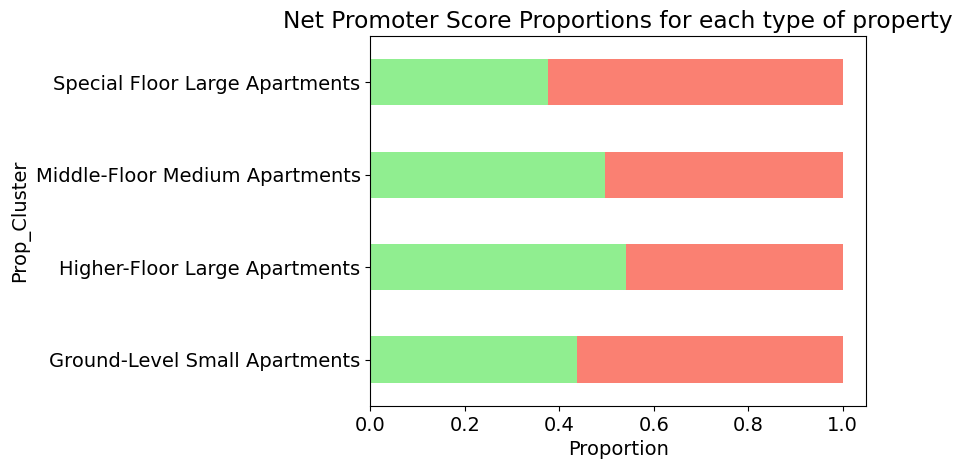

In [ ]:
prop_cluster_nps_counts = france.groupby(['Prop_Cluster', 'NetPromoterScore']).size().unstack(fill_value=0)

# Ensure all NPS labels are present in the counts DataFrame
for label in nps_labels:
    if label not in prop_cluster_nps_counts.columns:
        prop_cluster_nps_counts[label] = 0

# Reorder columns to match nps_labels order
prop_cluster_nps_counts = prop_cluster_nps_counts[nps_labels]

# Print counts for verification
print("Counts of each NPS category per Prop_Cluster:")
print(prop_cluster_nps_counts)

# Calculate proportions of each NPS category per Prop_Cluster
prop_cluster_nps_proportions = prop_cluster_nps_counts.div(prop_cluster_nps_counts.sum(axis=1), axis=0)

# Print proportions for verification
print("\nProportions of each NPS category per Prop_Cluster:")
print(prop_cluster_nps_proportions)

# Plot stacked horizontal bar plot for proportions of NPS categories per Prop_Cluster
plt.figure(figsize=(12, 6))
prop_cluster_nps_proportions.plot(kind='barh', stacked=True, color=nps_colors, legend=False)
plt.title('Net Promoter Score Proportions for each type of property')
plt.xlabel('Proportion')
plt.ylabel('Prop_Cluster')
plt.show()

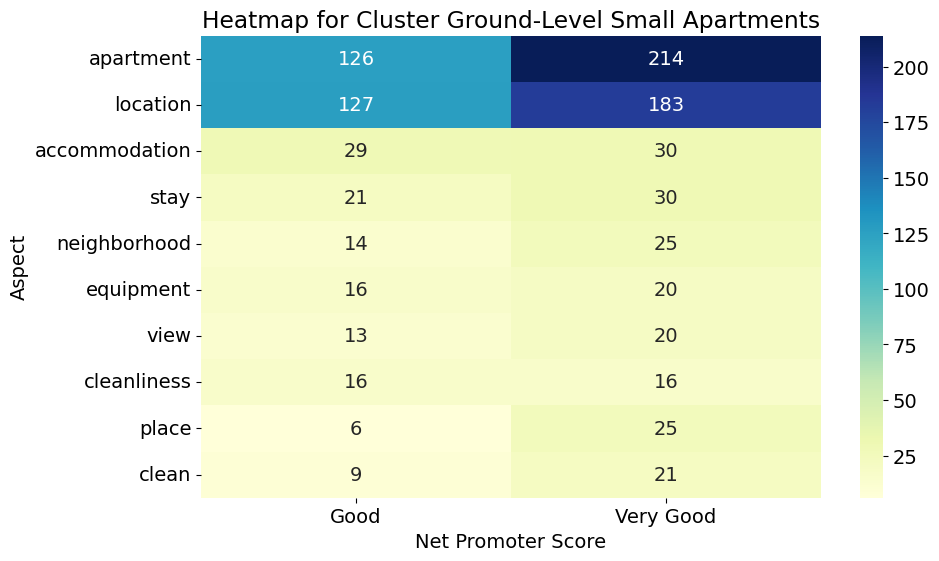

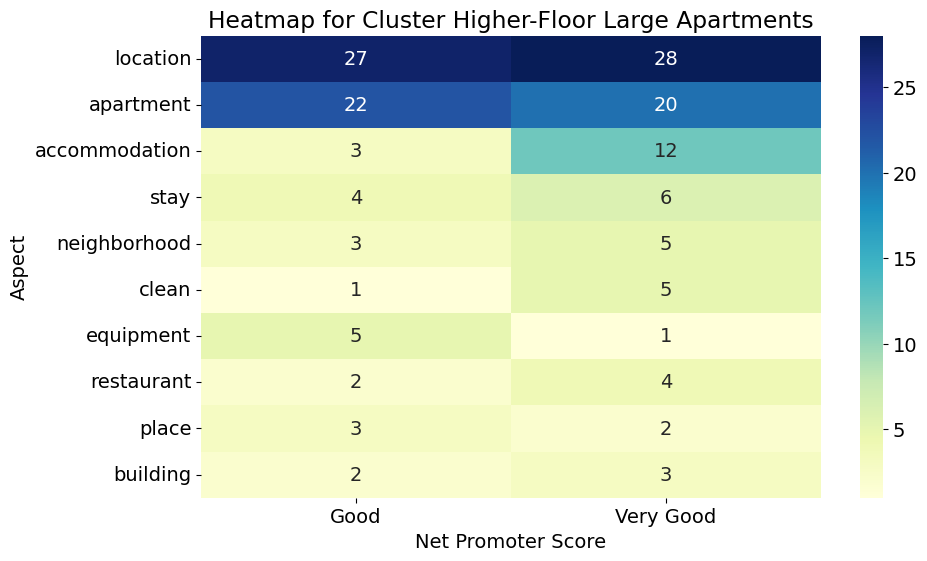

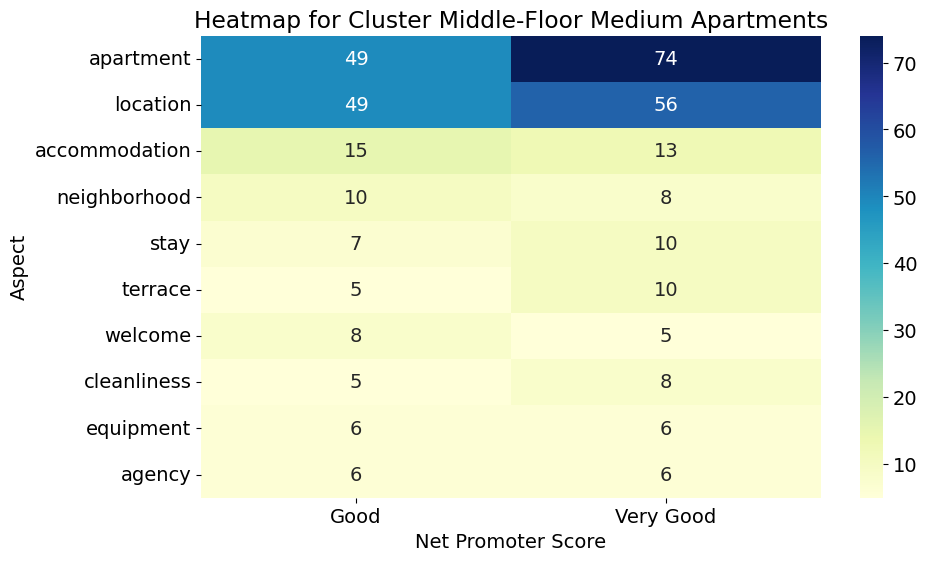

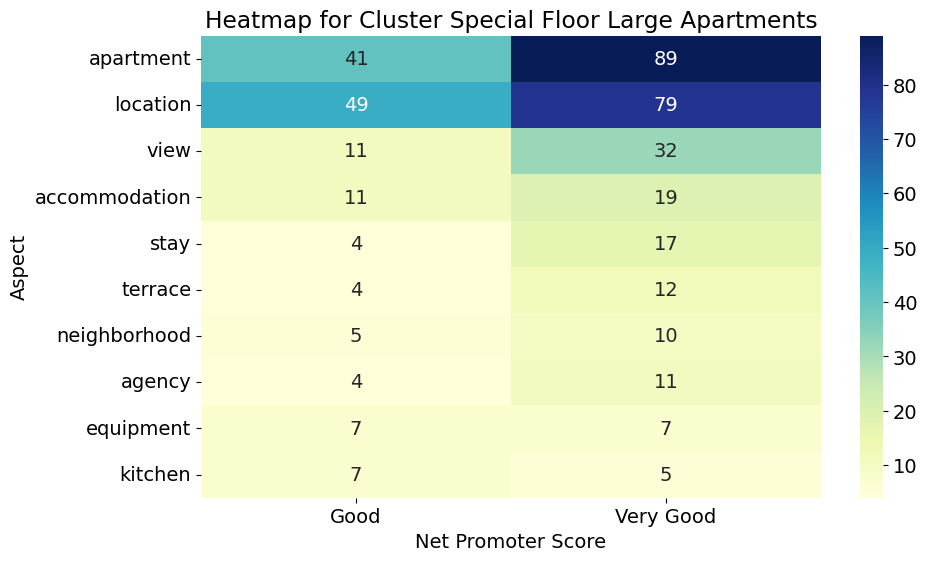

In [ ]:
nps_order = ['Good', 'Very Good']

# Grouping by 'Prop_Cluster'
cluster_groups = france.groupby('Prop_Cluster')
plt.rcParams.update({'font.size': 14})
for cluster, group in cluster_groups:
    # Count the frequency of each aspect and extract the top 10
    top_10_aspects = group['Aspects'].value_counts().nlargest(10).index

    # Create a pivot table to prepare data for heatmap
    pivot_table = group.pivot_table(index='Aspects', columns='NetPromoterScore', aggfunc='size', fill_value=0)
    pivot_table = pivot_table.loc[top_10_aspects, nps_order]  # Select only top 10 aspects and order NPS columns

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='d')  # 'd' format for integer
    plt.title(f"Heatmap for Cluster {cluster}")
    plt.xlabel("Net Promoter Score")
    plt.ylabel("Aspect")
    plt.show()

# Espanha

## Distribuição de NPS

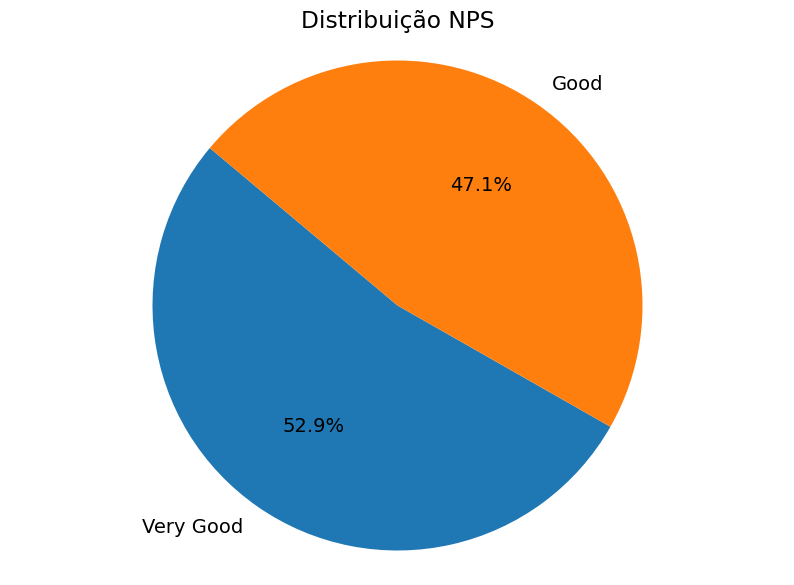

In [ ]:
nps_counts = esp['NetPromoterScore'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 7))
plt.pie(nps_counts, labels=nps_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição NPS')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

<ipython-input-568-17996e6ba19c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esp['review_date'] = pd.to_datetime(esp['review_date'])


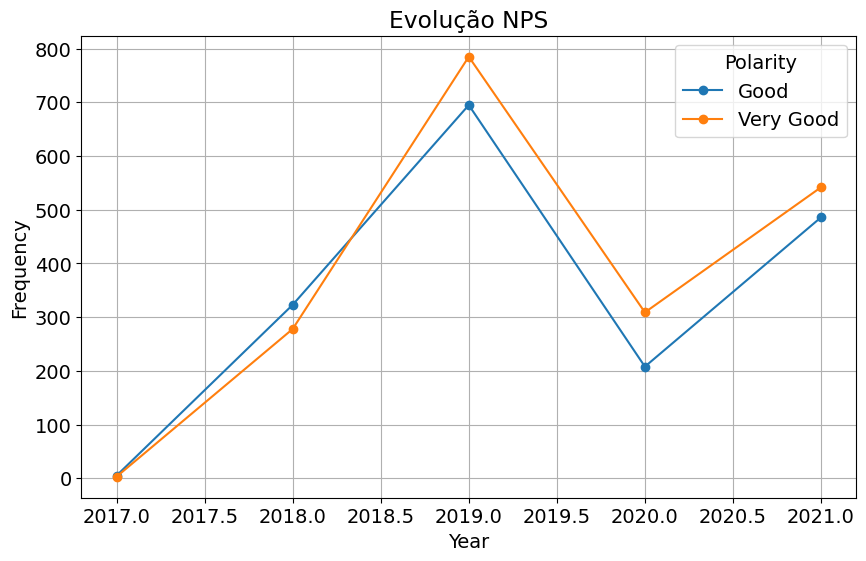

In [ ]:
esp['review_date'] = pd.to_datetime(esp['review_date'])

# Resample the data yearly and count the occurrences
yearly_data = esp.groupby([esp['review_date'].dt.year, 'NetPromoterScore']).size().unstack(fill_value=0)

# Plot
yearly_data.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Evolução NPS')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(title='Polarity')
plt.show()

## Wordcloud

In [ ]:
comments = esp['Aspects']
comments = esp['Aspects'].dropna().astype(str)
all_comments = ' '.join(comments)

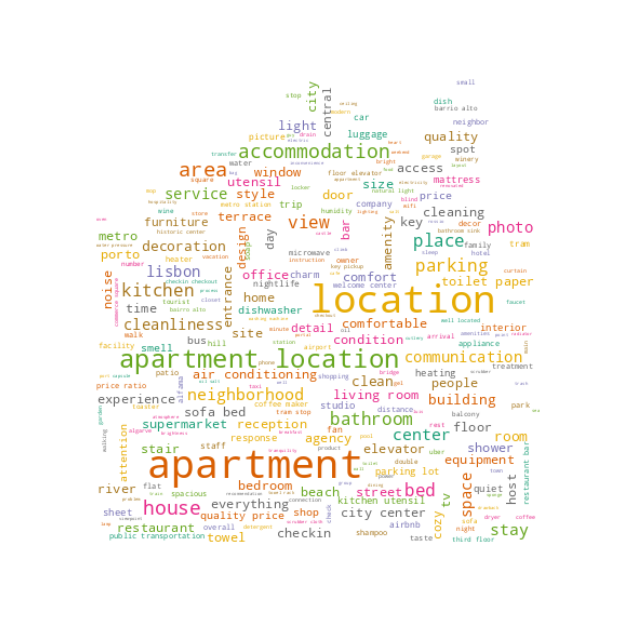

In [ ]:
wc = WordCloud(mask=mask, background_color="white",
               max_words=1000, max_font_size=1000,
               random_state=42, width=mask.shape[1]*2,
               height=mask.shape[0]*2,
               colormap='Dark2')  # Change to a darker colormap, e.g., 'Dark2'

wc.generate(all_comments)
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## Top 10 Aspectos e proporção NPS

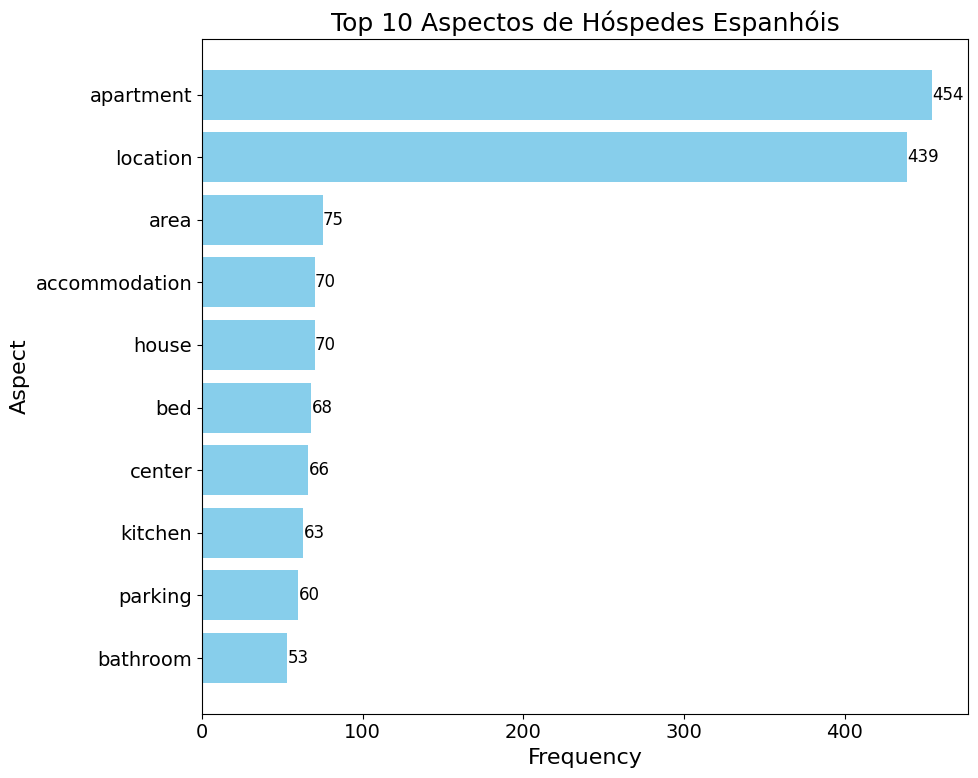

In [ ]:
all_aspects = ' '.join(esp['Aspects']).split()

# Count occurrences of each aspect
aspect_counts = pd.Series(all_aspects).value_counts()

# Take top 15 aspects
top_15_aspects = aspect_counts.head(10)

# Sort aspects from lower to higher frequency
top_15_aspects = top_15_aspects.sort_values()

# Plotting
plt.figure(figsize=(10, 8))  # Adjust size to fit the plot nicely

# Create horizontal bar plot
bars = plt.barh(top_15_aspects.index, top_15_aspects, color='skyblue')

# Annotate each bar with its frequency
for bar in bars:
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}',
             va='center', ha='left', fontsize=12)

plt.title('Top 10 Aspectos de Hóspedes Espanhóis', fontsize=18)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Aspect', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

<ipython-input-572-1d9cdf800a07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esp['NPS_Num'] = esp['NetPromoterScore'].map(nps_mapping)


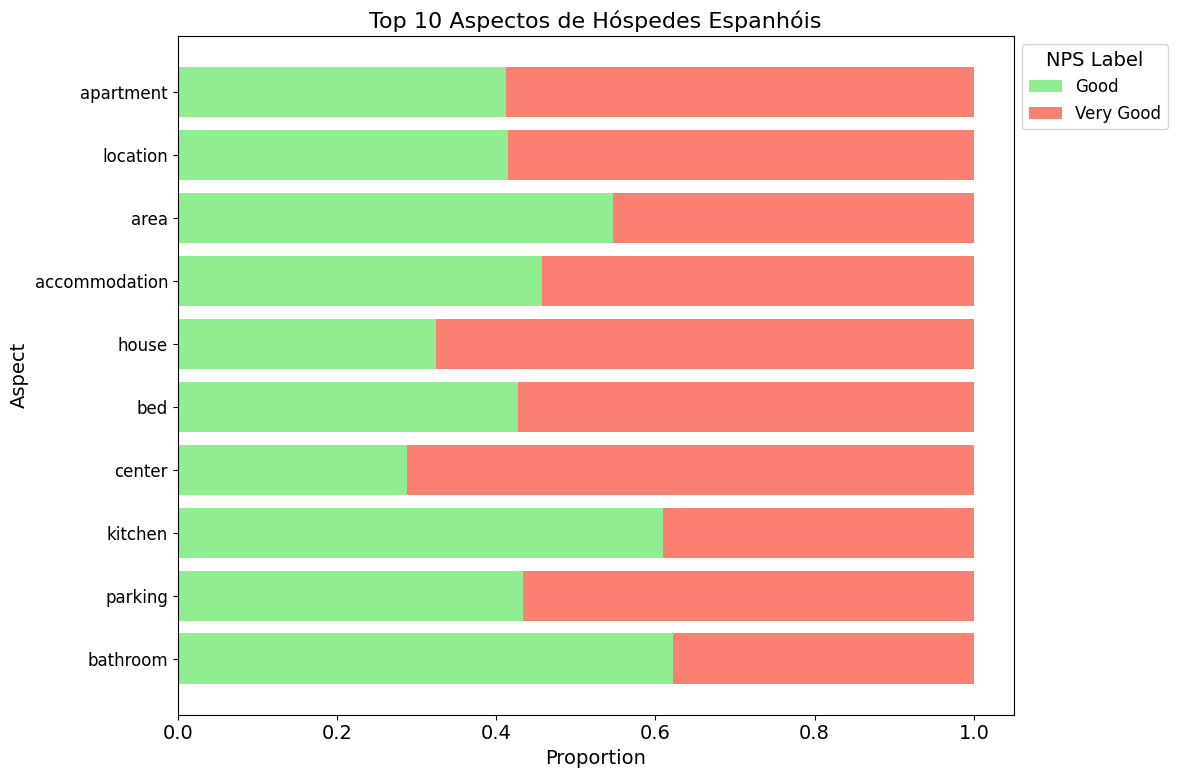

In [ ]:
nps_mapping = {'Neutral': 0, 'Good': 1, 'Very Good': 2}
esp['NPS_Num'] = esp['NetPromoterScore'].map(nps_mapping)

# Combine all aspects into a single string and split into individual aspects
all_aspects = ' '.join(esp['Aspects']).split()

# Count occurrences of each aspect
aspect_counts = pd.Series(all_aspects).value_counts()

# Take top 10 aspects
top_10_aspects = aspect_counts.head(10)

# Sort aspects from lower to higher frequency
top_10_aspects = top_10_aspects.sort_values()

# Calculate the proportion of each NPS category for the top 10 aspects
aspect_nps_proportion = {}
for aspect in top_10_aspects.index:
    aspect_reviews = esp[esp['Aspects'].str.contains(re.escape(aspect))]
    nps_counts = aspect_reviews['NetPromoterScore'].value_counts(normalize=True)
    nps_proportion = {'Neutral': 0, 'Good': 0, 'Very Good': 0}
    for nps_label, proportion in nps_counts.items():
        nps_proportion[nps_label] = proportion
    aspect_nps_proportion[aspect] = nps_proportion

# Define NPS labels and colors
nps_labels = ['Good', 'Very Good']
nps_colors = ['lightgreen', 'salmon']

# Plotting
plt.figure(figsize=(12, 8))

# Create stacked bar plot for each aspect
for i, aspect in enumerate(top_10_aspects.index):
    bottom_value = 0
    for j, label in enumerate(nps_labels):
        nps_proportion = aspect_nps_proportion[aspect][label]
        plt.barh(i, nps_proportion, color=nps_colors[j], label=label if i == 0 else "", left=bottom_value)
        bottom_value += nps_proportion

plt.title('Top 10 Aspectos de Hóspedes Espanhóis', fontsize=16)
plt.xlabel('Proportion', fontsize=14)
plt.ylabel('Aspect', fontsize=14)
plt.yticks(range(len(top_10_aspects.index)), top_10_aspects.index, fontsize=12)  # Increase font size for y-ticks
plt.legend(title='NPS Label', bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)  # Increase font size for legend
plt.tight_layout()

plt.show()

## Top 10 bigramas e proporção NPS

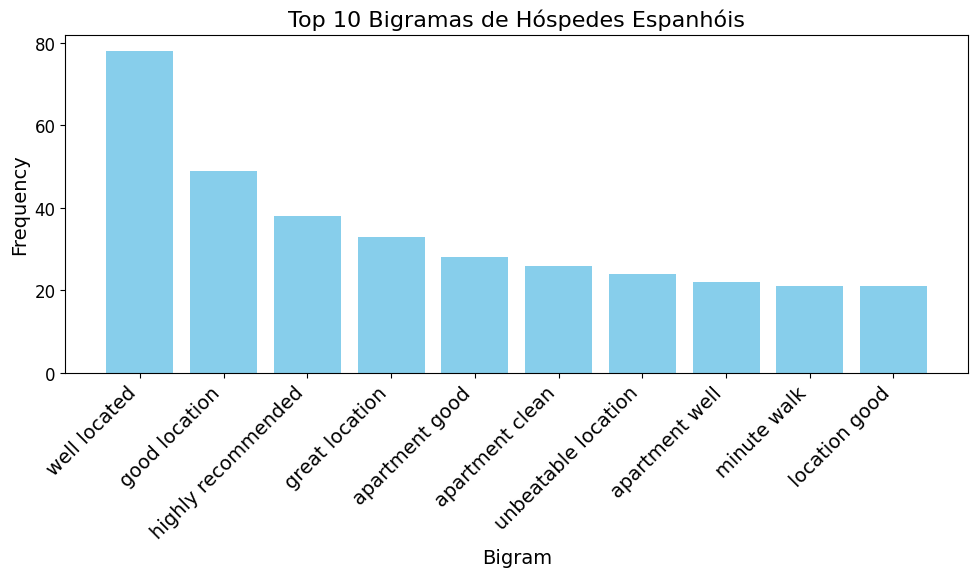

In [ ]:
esp_unique_reviews = esp.drop_duplicates(subset='ReservationId', keep='first')

# Tokenize the translated reviews
all_reviews = ' '.join(esp_unique_reviews['Translated'])
tokens = word_tokenize(all_reviews)

# Create bigrams
bigram_list = list(bigrams(tokens))

# Filter out specific bigrams
filtered_bigrams = [bigram for bigram in bigram_list if bigram not in [('like', 'home'), ('feel', 'like')]]

# Count occurrences of each bigram
bigram_counts = Counter(filtered_bigrams)

# Get the top N bigrams
top_n_bigrams = bigram_counts.most_common(10)  # Change 10 to your desired number of top bigrams

# Extract bigrams and their frequencies
bigrams_top, frequencies = zip(*top_n_bigrams)

# Plotting
plt.figure(figsize=(10, 6))

# Create bar plot for the top bigrams
plt.bar([f"{bigram[0]} {bigram[1]}" for bigram in bigrams_top], frequencies, color='skyblue')
plt.title('Top 10 Bigramas de Hóspedes Espanhóis', fontsize=16)
plt.xlabel('Bigram', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)  # Increase font size for x-ticks
plt.yticks(fontsize=12)  # Increase font size for y-ticks
plt.tight_layout()

plt.show()

<ipython-input-574-c5ecc5ae719d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esp['NPS_Num'] = esp['NetPromoterScore'].map(nps_mapping)


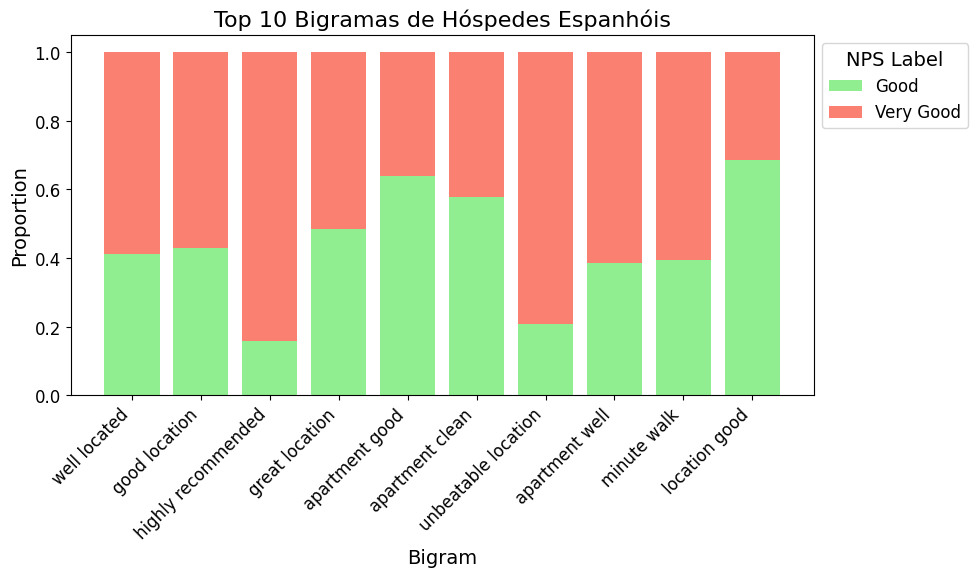

In [ ]:

# Map qualitative NPS values to numerical values
nps_mapping = {'Neutral': 0, 'Good': 1, 'Very Good': 2}
esp['NPS_Num'] = esp['NetPromoterScore'].map(nps_mapping)

# Filter out repeated ReservationId and keep only the first review associated with each unique ReservationId
esp_unique_reviews = esp.drop_duplicates(subset='ReservationId', keep='first')

# Tokenize the translated reviews
all_reviews = ' '.join(esp_unique_reviews['Translated'])
tokens = word_tokenize(all_reviews)

# Create bigrams
bigram_list = list(bigrams(tokens))

# Filter out specific bigrams
filtered_bigrams = [bigram for bigram in bigram_list if bigram not in [('like', 'home'), ('feel', 'like')]]

# Calculate the proportion of each category of NPS for each bigram
bigram_nps_proportion = {}
for bigram in filtered_bigrams:
    bigram_reviews = esp_unique_reviews[esp_unique_reviews['Translated'].str.contains(re.escape(' '.join(bigram)))]
    nps_counts = bigram_reviews['NetPromoterScore'].value_counts(normalize=True)
    nps_proportion = {'Neutral': 0, 'Good': 0, 'Very Good': 0}
    for nps_label, proportion in nps_counts.items():
        nps_proportion[nps_label] = proportion
    bigram_nps_proportion[bigram] = nps_proportion

# Count occurrences of each bigram
bigram_counts = Counter(filtered_bigrams)

# Get the top N bigrams
top_n_bigrams = bigram_counts.most_common(10)  # Change 10 to your desired number of top bigrams

# Extract bigrams and their frequencies
bigrams_top, frequencies = zip(*top_n_bigrams)

# Define NPS labels and colors
nps_labels = ['Good', 'Very Good']
nps_colors = ['lightgreen', 'salmon']
plt.figure(figsize=(10, 6))

# Create stacked bar plot for each bigram
for i, bigram in enumerate(bigrams_top):
    for j, label in enumerate(nps_labels):
        nps_proportion = bigram_nps_proportion[bigram][label]
        plt.bar(i, nps_proportion, color=nps_colors[j], label=label if i == 0 else None, bottom=sum(bigram_nps_proportion[bigram][nps_labels[k]] for k in range(j)))

plt.title('Top 10 Bigramas de Hóspedes Espanhóis', fontsize=16)
plt.xlabel('Bigram', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(range(len(bigrams_top)), [f"{bigram[0]} {bigram[1]}" for bigram in bigrams_top], rotation=45, ha='right', fontsize=12)  # Increase font size for x-ticks
plt.yticks(fontsize=12)  # Increase font size for y-ticks
plt.legend(title='NPS Label', bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)  # Increase font size for legend
plt.tight_layout()

plt.show()


## Clusters count e proporção NPS

<ipython-input-575-5822b4915b39>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=esp, y='Cluster_Labels', x=esp.groupby('Cluster_Labels').transform('count').iloc[:, 0], palette='Set3')


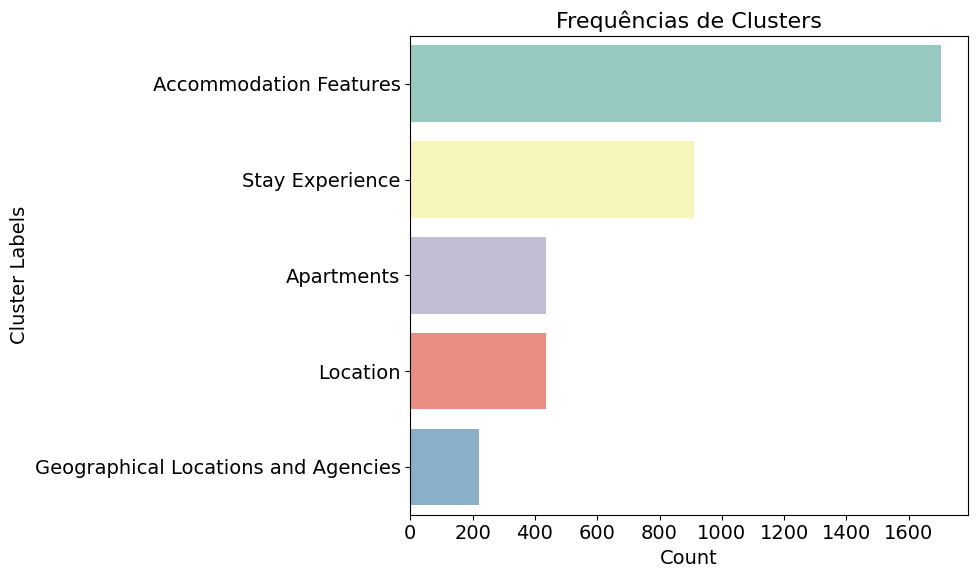

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=esp, y='Cluster_Labels', x=esp.groupby('Cluster_Labels').transform('count').iloc[:, 0], palette='Set3')
plt.title('Frequências de Clusters', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Cluster Labels', fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-ticks
plt.yticks(fontsize=14)  # Increase font size for y-ticks
plt.tight_layout()
plt.show()

Counts of each NPS category per cluster:
NetPromoterScore                     Neutral  Good  Very Good
Cluster_Labels                                               
Accommodation Features                     0   836        869
Apartments                                 0   184        253
Geographical Locations and Agencies        0   111        111
Location                                   0   182        253
Stay Experience                            0   436        476

Proportions of each NPS category per cluster:
NetPromoterScore                     Neutral      Good  Very Good
Cluster_Labels                                                   
Accommodation Features                   0.0  0.490323   0.509677
Apartments                               0.0  0.421053   0.578947
Geographical Locations and Agencies      0.0  0.500000   0.500000
Location                                 0.0  0.418391   0.581609
Stay Experience                          0.0  0.478070   0.521930


<Figure size 1200x800 with 0 Axes>

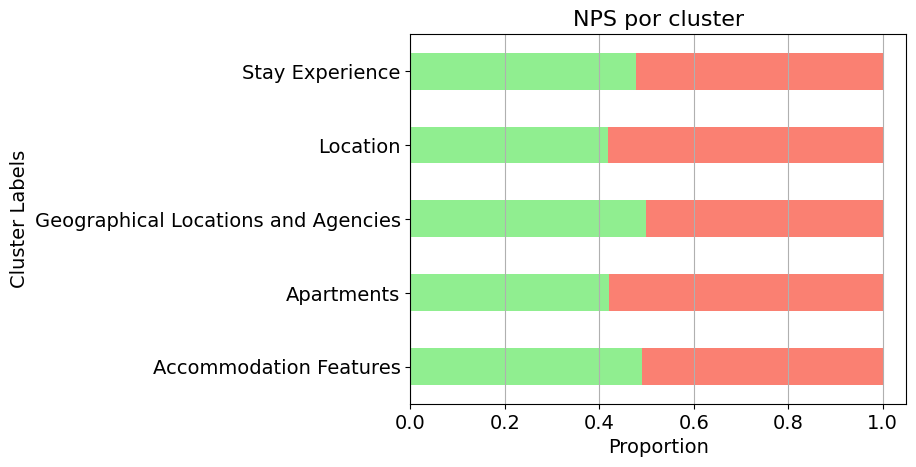

In [ ]:
nps_labels = ['Neutral', 'Good', 'Very Good']
nps_colors = ['skyblue', 'lightgreen', 'salmon']

# Calculate counts of each NPS category per cluster
cluster_nps_counts = esp.groupby(['Cluster_Labels', 'NetPromoterScore']).size().unstack(fill_value=0)

# Ensure all NPS labels are present in the counts DataFrame
for label in nps_labels:
    if label not in cluster_nps_counts.columns:
        cluster_nps_counts[label] = 0

# Reorder columns to match nps_labels order
cluster_nps_counts = cluster_nps_counts[nps_labels]

# Print counts for verification
print("Counts of each NPS category per cluster:")
print(cluster_nps_counts)

# Calculate proportions of each NPS category per cluster
cluster_nps_proportions = cluster_nps_counts.div(cluster_nps_counts.sum(axis=1), axis=0)

# Print proportions for verification
print("\nProportions of each NPS category per cluster:")
print(cluster_nps_proportions)

plt.rcParams.update({'font.size': 14})

# Plot stacked horizontal bar plot for proportions of NPS categories per cluster
plt.figure(figsize=(12, 8))  # Adjust figsize as needed
cluster_nps_proportions.plot(kind='barh', stacked=True, color=nps_colors, legend=False)
plt.title('NPS por cluster', fontsize=16)
plt.xlabel('Proportion')
plt.ylabel('Cluster Labels')
plt.yticks(rotation=0)  # Rotate y ticks if needed
plt.grid(axis='x')  # Add grid lines along x-axis for better readability
plt.show()

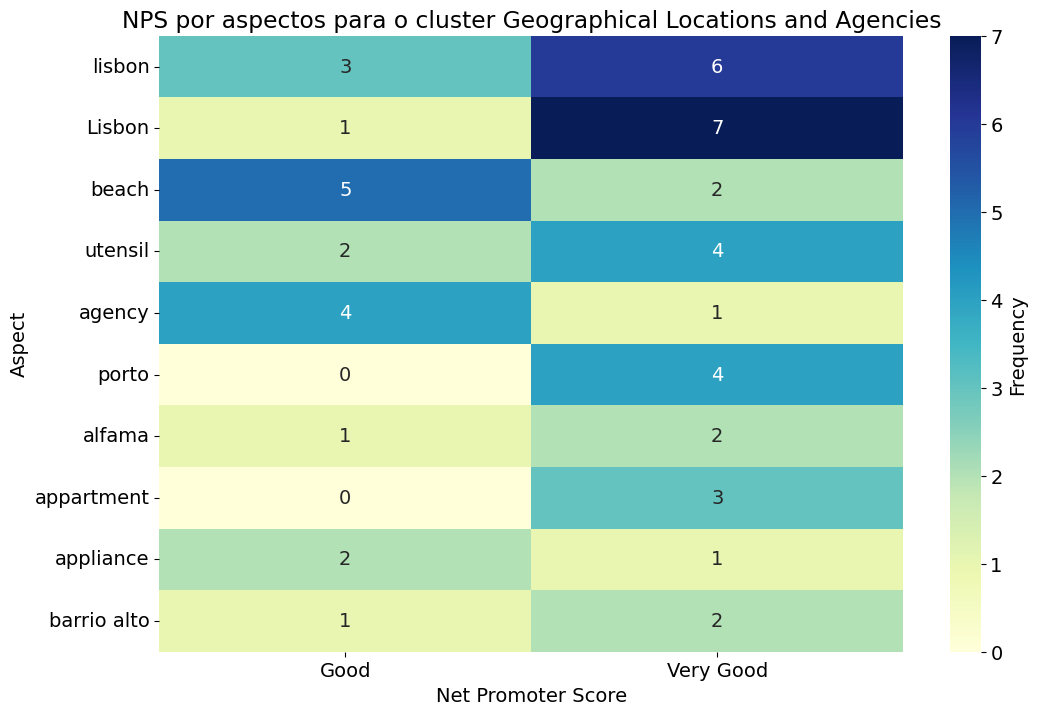

In [ ]:
filtered_data = esp[(esp['Cluster_Labels'] == 'Geographical Locations and Agencies') &
                       (esp['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]

# Counting the frequency of each aspect for each NetPromoterScore
aspect_nps_counts = filtered_data.pivot_table(index='Aspects', columns='NetPromoterScore', aggfunc='size', fill_value=0)

# Getting the top 10 most common aspects
top_aspects = aspect_nps_counts.sum(axis=1).nlargest(10).index

# Filtering the table to show only the top 10 aspects
top_aspect_nps_counts = aspect_nps_counts.loc[top_aspects]

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_aspect_nps_counts, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.title('NPS por aspectos para o cluster Geographical Locations and Agencies')
plt.xlabel('Net Promoter Score')
plt.ylabel('Aspect')
plt.show()

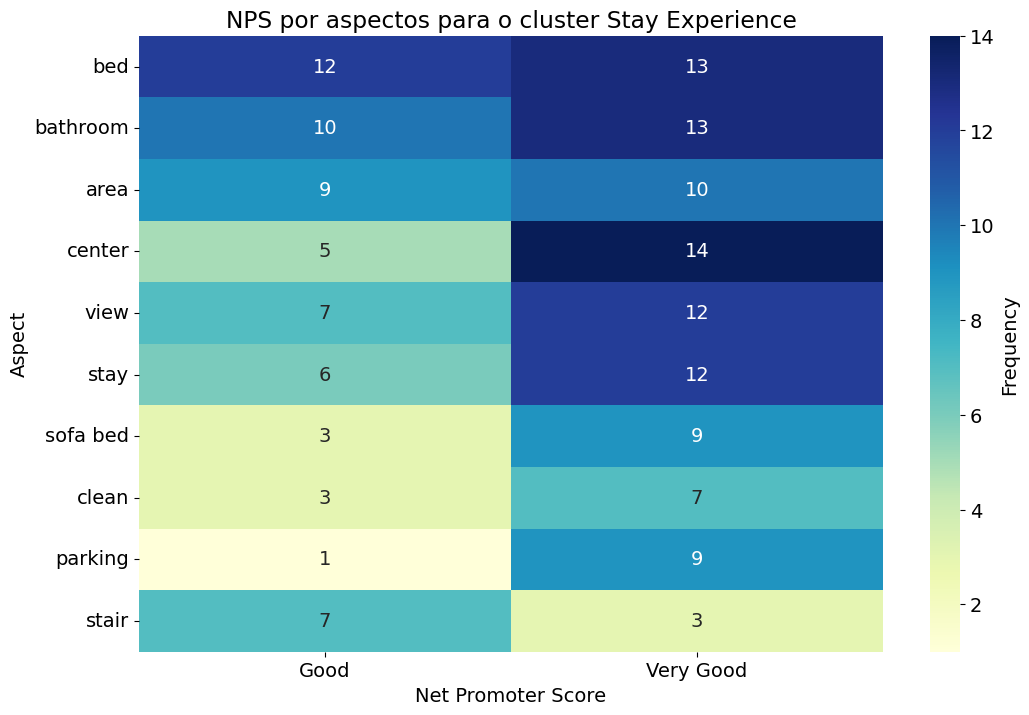

In [ ]:
filtered_data = esp[(esp['Cluster_Labels'] == 'Stay Experience') &
                       (esp['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]

# Counting the frequency of each aspect for each NetPromoterScore
aspect_nps_counts = filtered_data.pivot_table(index='Aspects', columns='NetPromoterScore', aggfunc='size', fill_value=0)

# Getting the top 10 most common aspects
top_aspects = aspect_nps_counts.sum(axis=1).nlargest(10).index

# Filtering the table to show only the top 10 aspects
top_aspect_nps_counts = aspect_nps_counts.loc[top_aspects]

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_aspect_nps_counts, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.title('NPS por aspectos para o cluster Stay Experience')
plt.xlabel('Net Promoter Score')
plt.ylabel('Aspect')
plt.show()

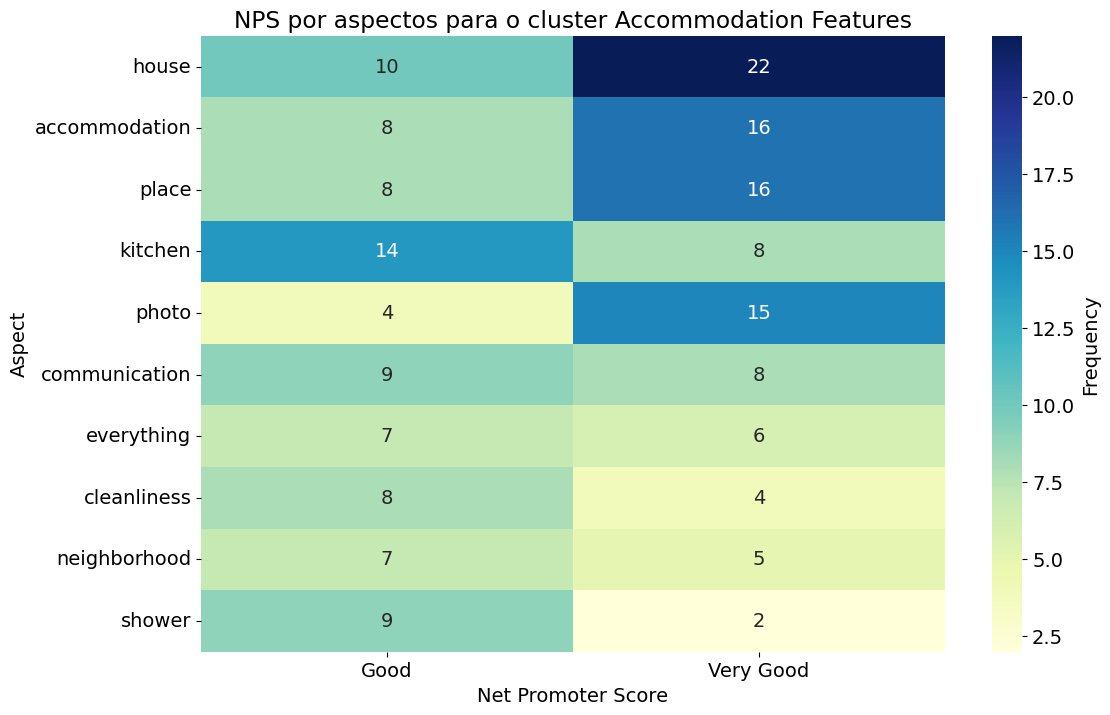

In [ ]:
filtered_data = esp[(esp['Cluster_Labels'] == 'Accommodation Features') &
                       (esp['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]

# Counting the frequency of each aspect for each NetPromoterScore
aspect_nps_counts = filtered_data.pivot_table(index='Aspects', columns='NetPromoterScore', aggfunc='size', fill_value=0)

# Getting the top 10 most common aspects
top_aspects = aspect_nps_counts.sum(axis=1).nlargest(10).index

# Filtering the table to show only the top 10 aspects
top_aspect_nps_counts = aspect_nps_counts.loc[top_aspects]

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_aspect_nps_counts, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Frequency'})
plt.title('NPS por aspectos para o cluster Accommodation Features')
plt.xlabel('Net Promoter Score')
plt.ylabel('Aspect')
plt.show()

In [ ]:
aspects = ['shower', 'bathroom','kitchen','accommodation','beach','lisbon']

# Initialize an empty list to store results for 'Good' NPS
all_results_good = []

# Initialize an empty list to store results for 'Very Good' NPS
all_results_very_good = []

# Iterate over each aspect
for aspect in aspects:
    # Filtered data for 'Good' NPS
    filtered_data_good = esp[(esp['Aspects'] == aspect) &
                            (esp['NetPromoterScore'] == 'Good') &
                            (esp['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]['Translated']

    # Create a list to store words that appear before the aspect in each sentence for 'Good' NPS
    before_words_good = []

    # Extract words that appear before the aspect in each sentence for 'Good' NPS
    for sentence in filtered_data_good:
        words = sentence.split()
        for i in range(1, len(words)):
            if words[i].lower() == aspect:
                if i > 0:
                    before_words_good.append(words[i-1].lower())

    # Count the frequency of each word for 'Good' NPS
    word_counts_good = pd.Series(before_words_good).value_counts().head(3)

    # Create a dictionary to store the results for 'Good' NPS for the current aspect
    results_good = {
        'Aspect': aspect,
        'Most Frequent Opinion': list(word_counts_good.index)
    }

    # Append results to the list for 'Good' NPS
    all_results_good.append(results_good)

    # Filtered data for 'Very Good' NPS
    filtered_data_very_good = esp[(esp['Aspects'] == aspect) &
                                  (esp['NetPromoterScore'] == 'Very Good') &
                                  (esp['reviewer_age_group'].isin(['25-29', '30-34', '35-39']))]['Translated']

    # Create a list to store words that appear before the aspect in each sentence for 'Very Good' NPS
    before_words_very_good = []

    # Extract words that appear before the aspect in each sentence for 'Very Good' NPS
    for sentence in filtered_data_very_good:
        words = sentence.split()
        for i in range(1, len(words)):
            if words[i].lower() == aspect:
                if i > 0:
                    before_words_very_good.append(words[i-1].lower())

    # Count the frequency of each word for 'Very Good' NPS
    word_counts_very_good = pd.Series(before_words_very_good).value_counts().head(3)

    # Create a dictionary to store the results for 'Very Good' NPS for the current aspect
    results_very_good = {
        'Aspect': aspect,
        'Most Frequent Opinion': list(word_counts_very_good.index)
    }

    # Append results to the list for 'Very Good' NPS
    all_results_very_good.append(results_very_good)

# Create DataFrames from the lists of results for 'Good' and 'Very Good' NPS
df_results_good = pd.DataFrame(all_results_good)
df_results_very_good = pd.DataFrame(all_results_very_good)

In [ ]:
df_results_good

Aspect            Most Frequent Opinion
0         shower   [decorated, overflowing, cold]
1       bathroom  [coming, drawback, cleanliness]
2        kitchen        [basic, comfortable, use]
3  accommodation          [good, walk, recommend]
4          beach            [close, walk, minute]
5         lisbon   [center, transportation, trip]

In [ ]:
df_results_very_good

Aspect          Most Frequent Opinion
0         shower       [highlight, comfortable]
1       bathroom       [comfortable, away, two]
2        kitchen  [wellequipped, full, perfect]
3  accommodation    [good, station, unbeatable]
4          beach                  [close, also]
5         lisbon        [day, district, return]

## Evolução de clusters ao longo do tempo

<ipython-input-583-15a4b6779bbd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esp.dropna(subset=['review_date'], inplace=True)
<ipython-input-583-15a4b6779bbd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esp['review_date'] = pd.to_datetime(esp['review_date'])


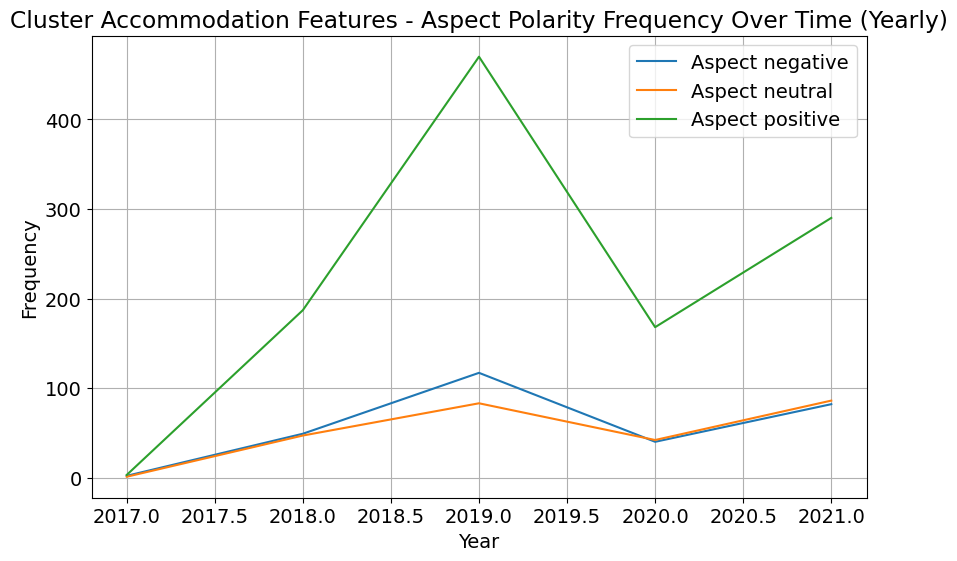

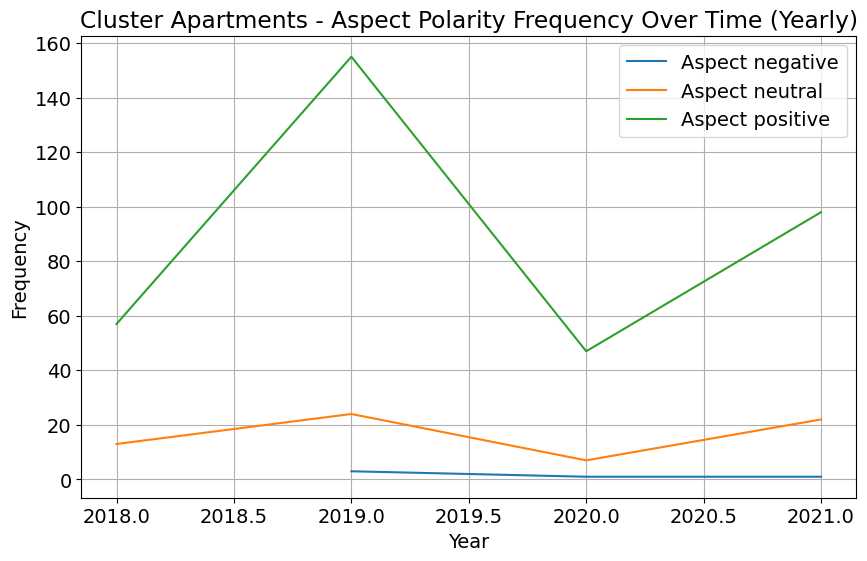

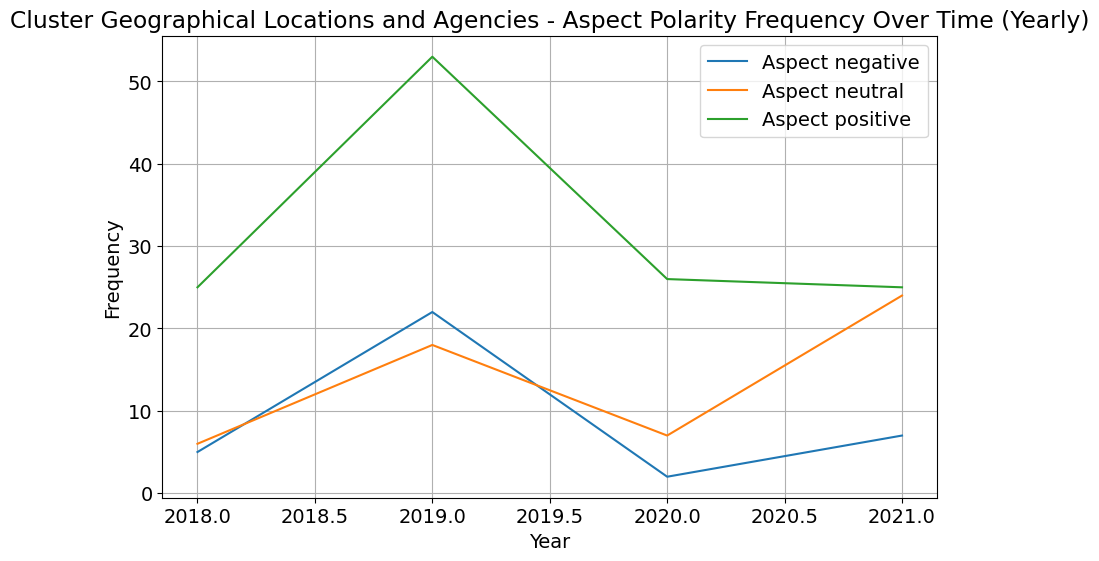

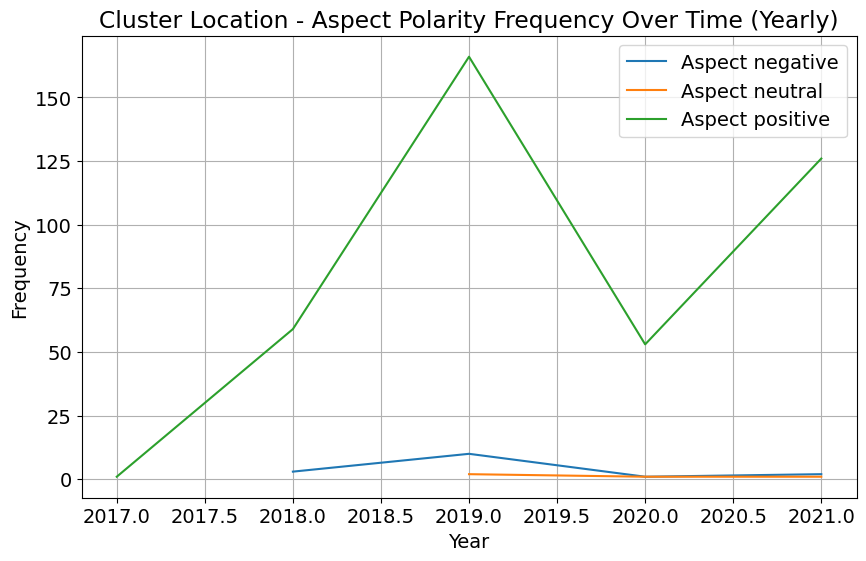

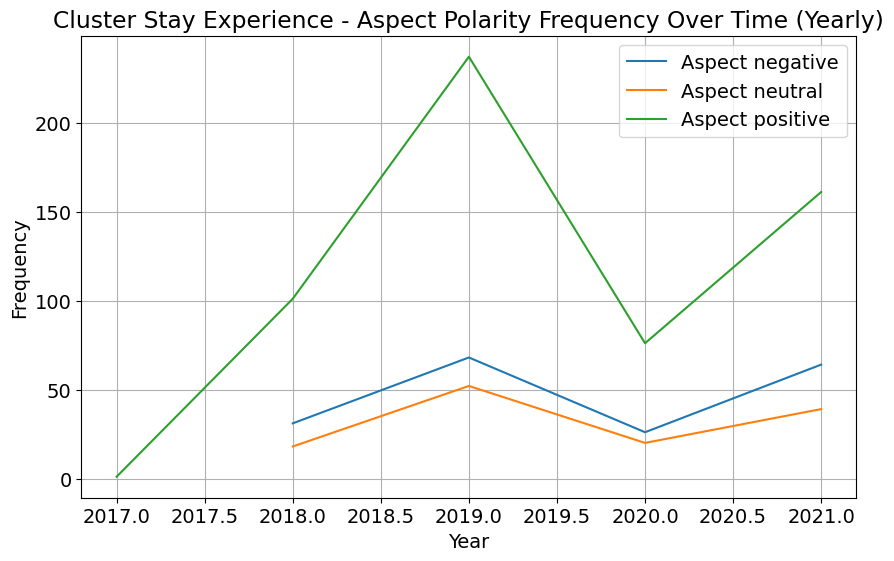

In [ ]:
esp.dropna(subset=['review_date'], inplace=True)

# Convert 'review_date' to datetime if it's not already
esp['review_date'] = pd.to_datetime(esp['review_date'])

# Group the data by 'Cluster_Labels'
grouped_data = esp.groupby('Cluster_Labels')

# Iterate over the groups, plotting the frequency of aspect polarity values yearly for each cluster
for group_name, group_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.title(f'Cluster {group_name} - Aspect Polarity Frequency Over Time (Anualmen)')
    for aspect, aspect_data in group_data.groupby('Aspects_Polarity'):
        aspect_freq_yearly = aspect_data.groupby(aspect_data['review_date'].dt.year).size()
        plt.plot(aspect_freq_yearly.index, aspect_freq_yearly.values, label=f'Aspect {aspect}')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
esp.dropna(subset=['review_date'], inplace=True)

# Convert 'review_date' to datetime if it's not already
esp['review_date'] = pd.to_datetime(esp['review_date'])

# Group the data by 'Cluster_Labels'
grouped_data = port.groupby('Cluster_Labels')

# Iterate over the groups, plotting the proportions of aspect polarity values yearly for each cluster
for group_name, group_data in grouped_data:
    plt.figure(figsize=(10, 6))
    plt.title(f'Cluster {group_name} - Aspect Polarity Proportions Over Time (Yearly)')
    for aspect, aspect_data in group_data.groupby('Aspects_Polarity'):
        aspect_count_yearly = aspect_data.groupby(aspect_data['review_date'].dt.year).size()
        total_reviews_yearly = group_data['review_date'].dt.year.value_counts()
        aspect_proportions_yearly = aspect_count_yearly.div(total_reviews_yearly)
        plt.plot(aspect_proportions_yearly.index, aspect_proportions_yearly.values, label=f'Aspect {aspect}')
    plt.xlabel('Year')
    plt.ylabel('Proportion')
    plt.legend()
    plt.grid(True)
    plt.show()

<ipython-input-584-8a71493841be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esp.dropna(subset=['review_date'], inplace=True)
<ipython-input-584-8a71493841be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esp['review_date'] = pd.to_datetime(esp['review_date'])


## Análise relativa a faixa etária

In [ ]:
age_group_counts = esp['reviewer_age_group'].value_counts()
top_2_age_groups = age_group_counts.head(3).index.tolist()
print("Top 2 Age Groups:", top_2_age_groups)

Top 2 Age Groups: ['25-29', '30-34', '45-49']


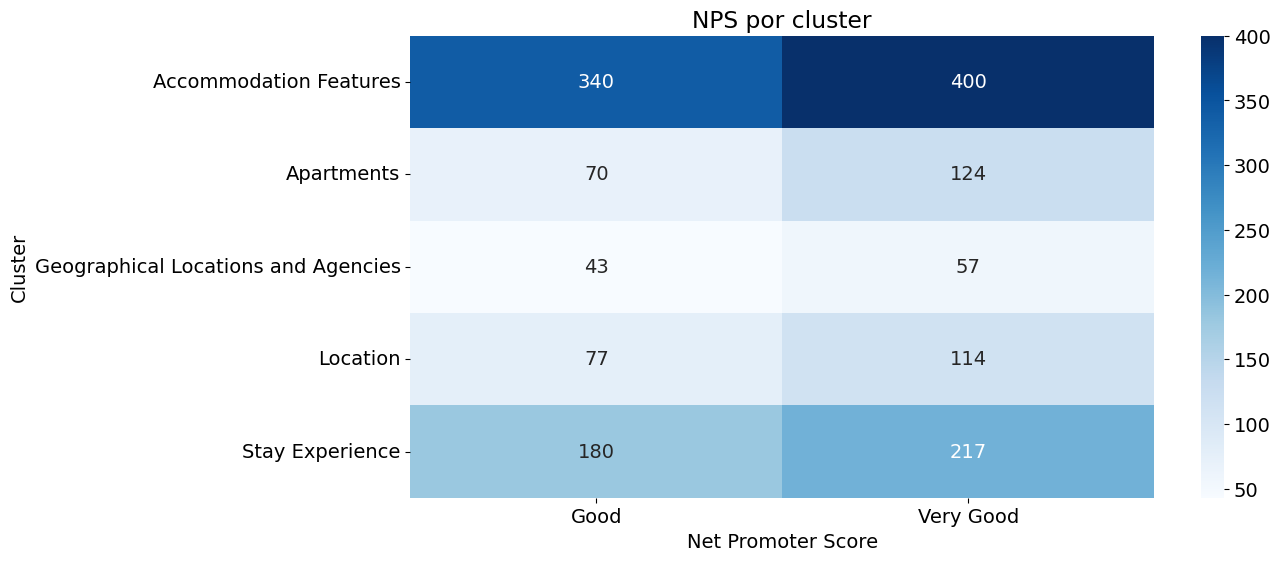

In [ ]:
selected_age_groups = ['25-29', '30-34', '35-39']

plt.rcParams.update({'font.size': 14})

# Filter the DataFrame for the selected age groups
selected_age_df = esp[esp['reviewer_age_group'].isin(selected_age_groups)]

# Group by cluster and Net Promoter Score and count the values
heatmap_data = selected_age_df.groupby(['Cluster_Labels', 'NetPromoterScore']).size().unstack(fill_value=0)

# Reorder the columns to preserve the original order
heatmap_data = heatmap_data[['Good', 'Very Good']]

# Plot the Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
plt.title('NPS por cluster')
plt.xlabel('Net Promoter Score')
plt.ylabel('Cluster')
plt.show()

## Análise relativa a tipo de propriedades

<ipython-input-587-64a4723bd322>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=esp, y='Prop_Cluster', x=esp.groupby('Prop_Cluster').transform('count').iloc[:, 0], palette='Set3', orient='h')


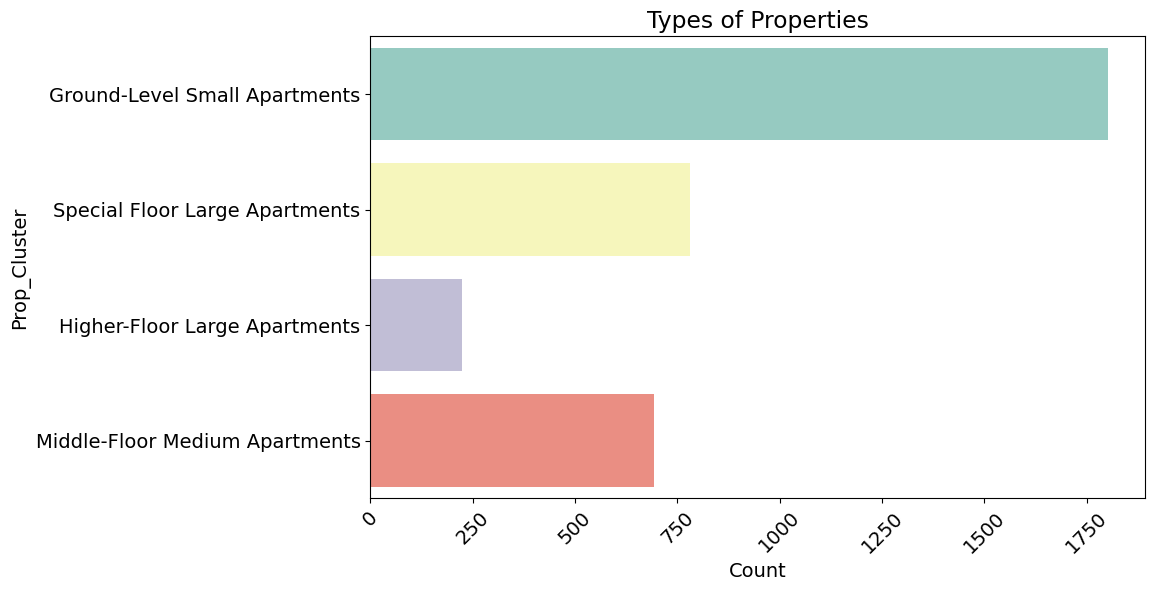

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=esp, y='Prop_Cluster', x=esp.groupby('Prop_Cluster').transform('count').iloc[:, 0], palette='Set3', orient='h')
plt.title('Types of Properties')
plt.xlabel('Count')
plt.ylabel('Prop_Cluster')
plt.xticks(rotation=45)  # Rotate x-labels for better readability if necessary
plt.show()


Counts of each NPS category per Prop_Cluster:
NetPromoterScore                Neutral  Good  Very Good
Prop_Cluster                                            
Ground-Level Small Apartments         0   781       1022
Higher-Floor Large Apartments         0   115        110
Middle-Floor Medium Apartments        0   376        316
Special Floor Large Apartments        0   371        410

Proportions of each NPS category per Prop_Cluster:
NetPromoterScore                Neutral      Good  Very Good
Prop_Cluster                                                
Ground-Level Small Apartments       0.0  0.433167   0.566833
Higher-Floor Large Apartments       0.0  0.511111   0.488889
Middle-Floor Medium Apartments      0.0  0.543353   0.456647
Special Floor Large Apartments      0.0  0.475032   0.524968


<Figure size 1200x600 with 0 Axes>

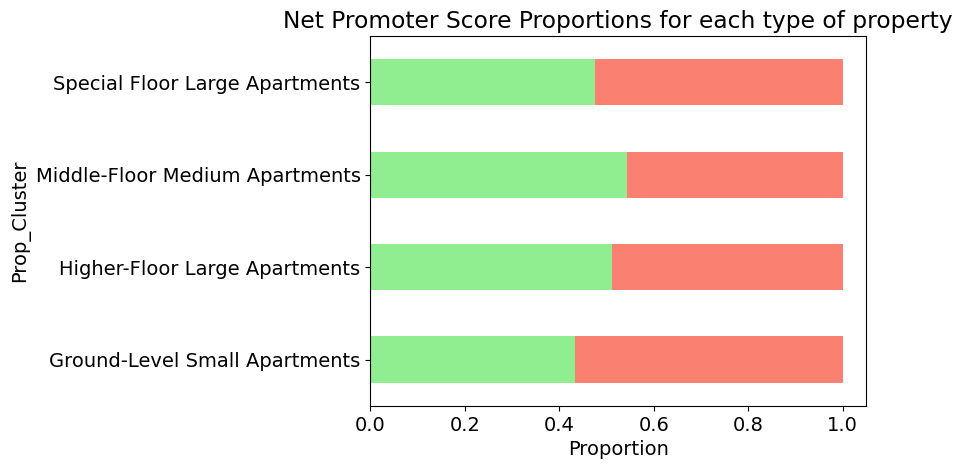

In [ ]:
prop_cluster_nps_counts = esp.groupby(['Prop_Cluster', 'NetPromoterScore']).size().unstack(fill_value=0)

# Ensure all NPS labels are present in the counts DataFrame
for label in nps_labels:
    if label not in prop_cluster_nps_counts.columns:
        prop_cluster_nps_counts[label] = 0

# Reorder columns to match nps_labels order
prop_cluster_nps_counts = prop_cluster_nps_counts[nps_labels]

# Print counts for verification
print("Counts of each NPS category per Prop_Cluster:")
print(prop_cluster_nps_counts)

# Calculate proportions of each NPS category per Prop_Cluster
prop_cluster_nps_proportions = prop_cluster_nps_counts.div(prop_cluster_nps_counts.sum(axis=1), axis=0)

# Print proportions for verification
print("\nProportions of each NPS category per Prop_Cluster:")
print(prop_cluster_nps_proportions)

# Plot stacked horizontal bar plot for proportions of NPS categories per Prop_Cluster
plt.figure(figsize=(12, 6))
prop_cluster_nps_proportions.plot(kind='barh', stacked=True, color=nps_colors, legend=False)
plt.title('Net Promoter Score Proportions for each type of property')
plt.xlabel('Proportion')
plt.ylabel('Prop_Cluster')
plt.show()

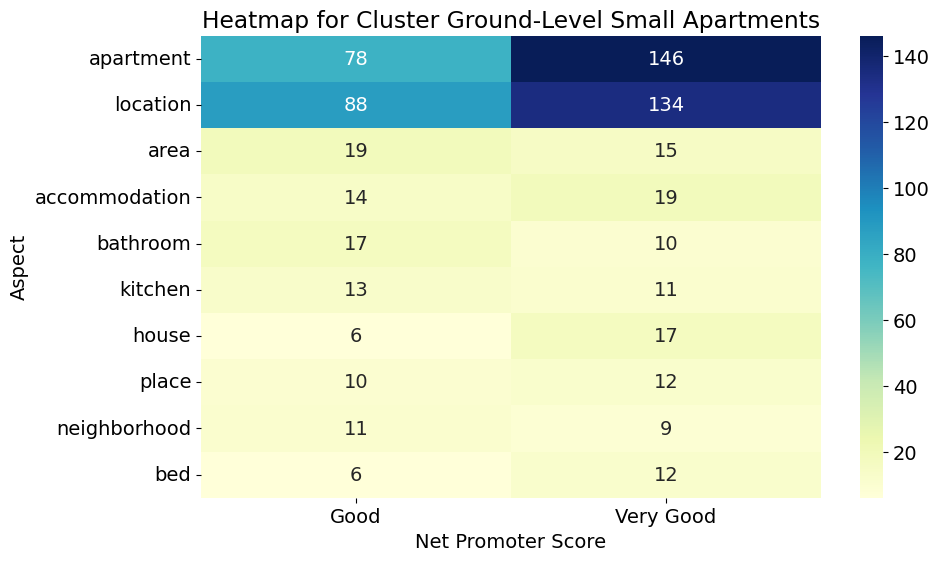

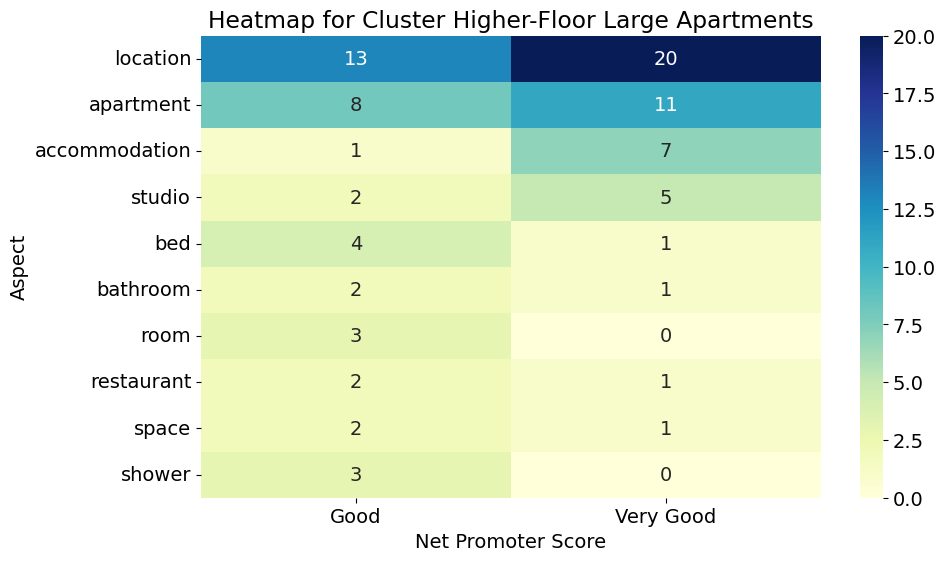

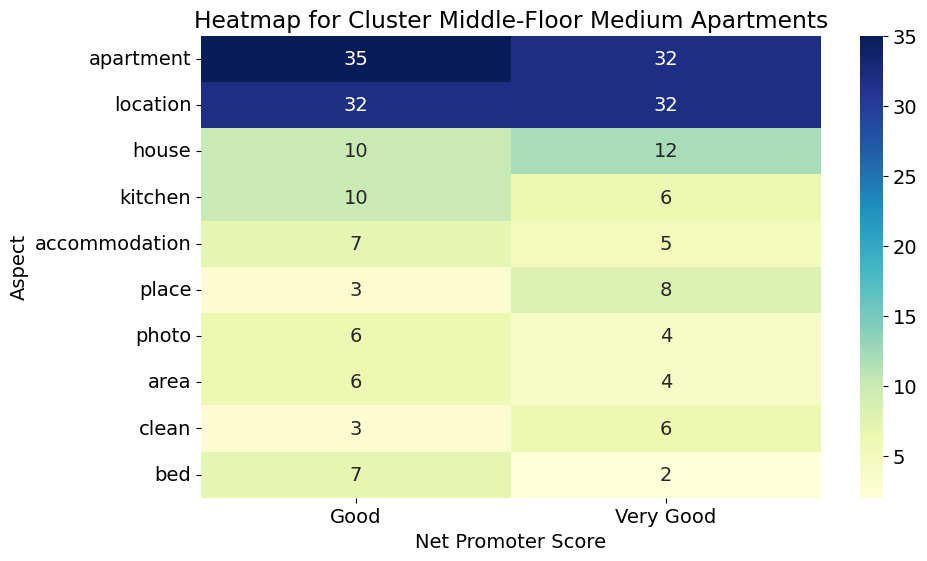

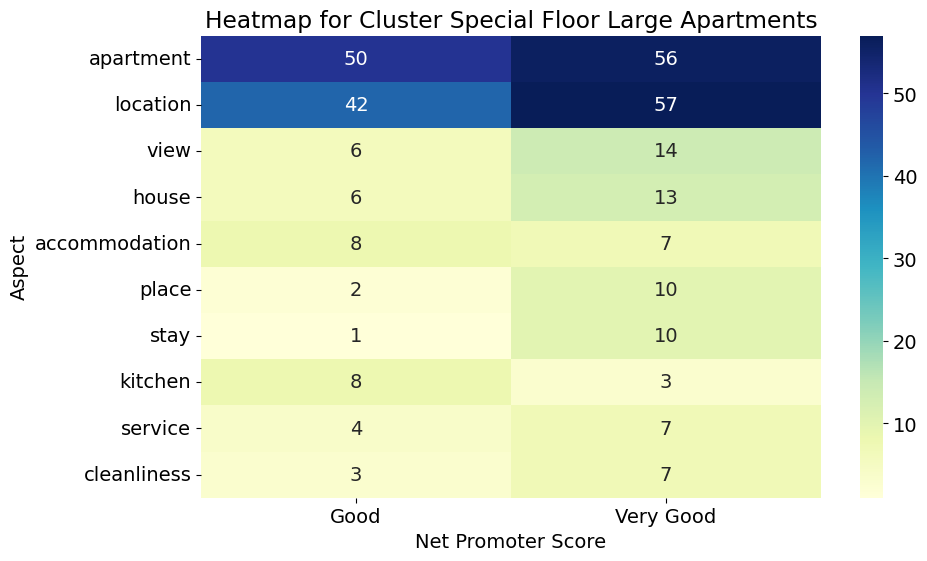

In [ ]:
nps_order = ['Good', 'Very Good']

# Grouping by 'Prop_Cluster'
cluster_groups = esp.groupby('Prop_Cluster')
plt.rcParams.update({'font.size': 14})
for cluster, group in cluster_groups:
    # Count the frequency of each aspect and extract the top 10
    top_10_aspects = group['Aspects'].value_counts().nlargest(10).index

    # Create a pivot table to prepare data for heatmap
    pivot_table = group.pivot_table(index='Aspects', columns='NetPromoterScore', aggfunc='size', fill_value=0)
    pivot_table = pivot_table.loc[top_10_aspects, nps_order]  # Select only top 10 aspects and order NPS columns

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='d')  # 'd' format for integer
    plt.title(f"Heatmap for Cluster {cluster}")
    plt.xlabel("Net Promoter Score")
    plt.ylabel("Aspect")
    plt.show()

## Análise relativa ao preço da reserva

In [ ]:
esp.columns

Index(['ReservationId', 'RatingValue', 'Comments', 'Language', 'Translated',
       'Polarity', 'NetPromoterScore', 'Aspects', 'Aspects_Polarity',
       'Aspect_vectors', 'Cluster_Labels', 'reviewer_age_group',
       'reviewer_nationality', 'review_date', 'valor_reserva', 'Prop_Cluster',
       'NPS_Num'],
      dtype='object')

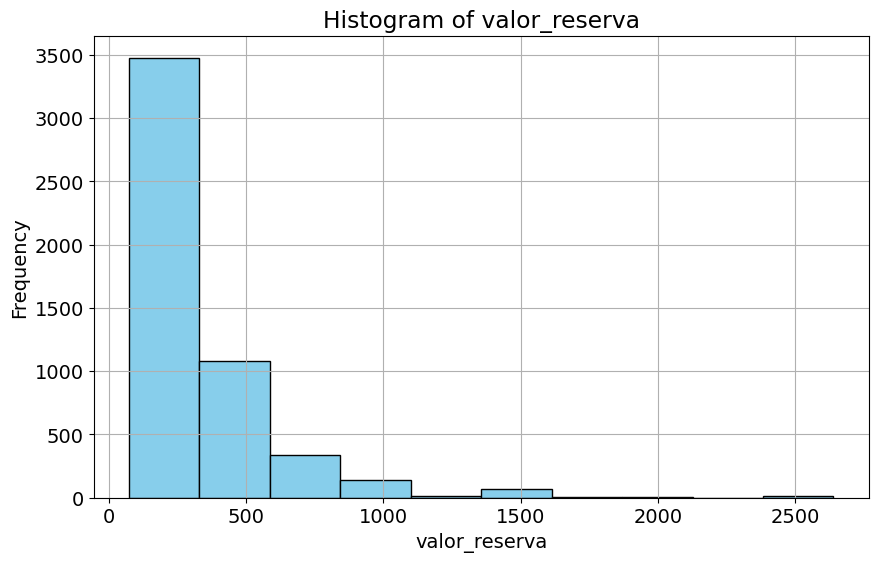

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(france['valor_reserva'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of valor_reserva')
plt.xlabel('valor_reserva')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
france

ReservationId  RatingValue  \
5         1879130683            8   
6         1879130683            8   
7         1879130683            8   
8         1879130683            8   
9         1879130683            8   
...              ...          ...   
11889     1879188226            5   
11890     1879188226            5   
11891     1879188226            5   
11892     1879188226            5   
11893     1879188226            5   

                                                Comments     Language  \
5      Le logement est très très bien situé, propre d...  __label__fr   
6      Le logement est très très bien situé, propre d...  __label__fr   
7      Le logement est très très bien situé, propre d...  __label__fr   
8      Le logement est très très bien situé, propre d...  __label__fr   
9      Le logement est très très bien situé, propre d...  __label__fr   
...                                                  ...          ...   
11889  Localização perfeita no centro de Lisboa, perm...  __label__pt   
11890  Localização perfeita no centro de Lisboa, perm...  __label__pt   
11891  Localização perfeita no centro de Lisboa, perm...  __label__pt   
11892  Localização perfeita no centro de Lisboa, perm...  __label__pt   
11893  Localização perfeita no centro de Lisboa, perm...  __label__pt   

                                              Translated  Polarity  \
5      accommodation well located clean overall also ...  Positive   
6      accommodation well located clean overall also ...  Positive   
7      accommodation well located clean overall also ...  Positive   
8      accommodation well located clean overall also ...  Positive   
9      accommodation well located clean overall also ...  Positive   
...                                                  ...       ...   
11889  perfect location center lisbon allowing enjoy ...  Positive   
11890  perfect location center lisbon allowing enjoy ...  Positive   
11891  perfect location center lisbon allowing enjoy ...  Positive   
11892  perfect location center lisbon allowing enjoy ...  Positive   
11893  perfect location center lisbon allowing enjoy ...  Positive   

      NetPromoterScore            Aspects Aspects_Polarity  \
5                 Good      accommodation         positive   
6                 Good           location         positive   
7                 Good  concierge service         positive   
8                 Good        cleanliness         positive   
9                 Good              space         positive   
...                ...                ...              ...   
11889        Very Good           location         positive   
11890        Very Good       neighborhood         positive   
11891        Very Good          apartment         positive   
11892        Very Good         decoration         positive   
11893        Very Good            bedding         positive   

                                          Aspect_vectors  \
5      [-0.05862487  0.00386601 -0.33326983  0.088091...   
6      [ 3.2019703   0.44487393 -2.1898077   0.115572...   
7      [ 2.2176492   0.7361839   2.2399268  -3.089105...   
8      [ 1.1196895   0.51563734  1.477156    0.946107...   
9      [-0.11217507 -1.3195558  -1.2931359  -0.874083...   
...                                                  ...   
11889  [ 3.2019703   0.44487393 -2.1898077   0.115572...   
11890  [ 1.4271013   1.0325927  -0.16060044  0.591584...   
11891  [-0.6586827  -0.49340886 -0.61936396  0.181167...   
11892  [ 0.38777208  0.17033212  0.3598127   0.816071...   
11893  [ 1.4040385e-01 -6.7008829e-01 -3.8321522e-01 ...   

               Cluster_Labels reviewer_age_group reviewer_nationality  \
5      Accommodation Features              45-49                   FR   
6                    Location              45-49                   FR   
7             Stay Experience              45-49                   FR   
8      Accommodation Features              45-49                   FR   
9            